In [1]:
import os
import sys
import ast
from staticfg.builder import CFGBuilder
import astpretty
import yaml
import math

import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

from hardwareModel import HardwareModel
import hardwareModel
from simulate import ConcreteSimulator
import sim_util
import schedule

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(
    context="talk", style="white", palette="bright", rc={"figure.figsize": (5, 4)}
)
plt.rcParams["figure.dpi"] = 192
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

In [3]:
rng = np.random.default_rng(0)

In [4]:
filepath = "benchmarks/models/matmult.py"
src_file =  open(filepath, 'r')
src = src_file.read() 
tree = ast.parse(src, mode='exec')
cfg = CFGBuilder().build_from_src('main.c', src)

In [68]:
cfg.build_visual('test_cfg', format='png')

In [ ]:
astpretty.pprint(tree, show_offsets=False, indent='  ',)

## test AST node transformer

In [7]:
code = "\
def tmp(x):\n \
    x = 3\n \
    return x\n \
\n\
def nested_func(interesting_func, y):\n \
    z = intereseting_func(y)\n \
    return z\n \
\n\
def read_weights_from_file(a):\n \
    v = 0\n \
    return a * 276345\n \
\n\
a = 20\n\
\n\
w, v = read_weights_from_file()\n \
"
# 

tree = ast.parse(code)

astpretty.pprint(tree, show_offsets=False, indent='  ',)

Module(
  body=[
    FunctionDef(
      name='tmp',
      args=arguments(
        posonlyargs=[],
        args=[arg(arg='x', annotation=None, type_comment=None)],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[],
      ),
      body=[
        Assign(
          targets=[Name(id='x', ctx=Store())],
          value=Constant(value=3, kind=None),
          type_comment=None,
        ),
        Return(
          value=Name(id='x', ctx=Load()),
        ),
      ],
      decorator_list=[],
      returns=None,
      type_comment=None,
    ),
    FunctionDef(
      name='nested_func',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='interesting_func', annotation=None, type_comment=None),
          arg(arg='y', annotation=None, type_comment=None),
        ],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[],
      ),
      body=[
        Assign(
     

In [13]:
class testTransformer(ast.NodeTransformer):
    def visit_Assign(self, node):
        if type(node.value) == ast.Call and node.value.func == ast.Name:
              print(node.value.func.id)
              if ("file" in node.value.func.id and "read" in node.value.func.id):
                    print("Found file read")
                    # change the node.targets[0] name to include _NVM.
                    if type(node.targets[0]) == ast.Name:
                        node.targets[0].id = node.targets[0].id + "_NVM"
                    elif type(node.targets[0]) == ast.Tuple:
                        for target in node.targets[0].elts:
                            target.id = target.id + "_NVM"
            #   print(node.value.args[0].id)
        astpretty.pprint(node, show_offsets=False, indent='  ',)
        return node
        


In [8]:
a = []
if a:
    print("a is not empty")
else:
    print("a is empty")

a is empty


In [14]:
testTransformer().visit(tree)

Assign(
  targets=[Name(id='x', ctx=Store())],
  value=Constant(value=3, kind=None),
  type_comment=None,
)
intereseting_func
Assign(
  targets=[Name(id='z', ctx=Store())],
  value=Call(
    func=Name(id='intereseting_func', ctx=Load()),
    args=[Name(id='y', ctx=Load())],
    keywords=[],
  ),
  type_comment=None,
)
Assign(
  targets=[Name(id='v', ctx=Store())],
  value=Constant(value=0, kind=None),
  type_comment=None,
)
read_weights_from_file
Found file read
Assign(
  targets=[
    Tuple(
      elts=[
        Name(id='w_NVM', ctx=Store()),
        Name(id='v_NVM', ctx=Store()),
      ],
      ctx=Store(),
    ),
  ],
  value=Call(
    func=Name(id='read_weights_from_file', ctx=Load()),
    args=[],
    keywords=[],
  ),
  type_comment=None,
)


## test object sizes

In [7]:
# from matmult.py
a = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
b = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
c = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
d = [9, 9, 9]

i, j = int(0), float(0)

print(f"sizes: i(int): {sys.getsizeof(i)}, j(float): {sys.getsizeof(j)} a: {sys.getsizeof(a)}, a[0][0]: {sys.getsizeof(a[0][0])}, b: {sys.getsizeof(b)}, b[0][0]: {sys.getsizeof(b[0][0])}, c: {sys.getsizeof(c)}, c[0][0]: {sys.getsizeof(c[0][0])}, d: {sys.getsizeof(d)}")
print(f"types: i(int): {type(i)}, j(float): {type(j)} a: {type(a)}, a[0][0]: {type(a[0][0])}, b: {type(b)}, b[0][0]: {type(b[0][0])}, c: {type(c)}, c[0][0]: {type(c[0][0])}, d: {type(d)}")
print(f"lens: a: {len(a)}, a[0]: {len(a[0])}, b: {len(b)}, b[0]: {len(b[0])}, c: {len(c)}, c[0]: {len(c[0])}, d: {len(d)}")

sizes: i(int): 28, j(float): 24 a: 80, a[0][0]: 28, b: 80, b[0][0]: 28, c: 80, c[0][0]: 28, d: 88
types: i(int): <class 'int'>, j(float): <class 'float'> a: <class 'list'>, a[0][0]: <class 'int'>, b: <class 'list'>, b[0][0]: <class 'int'>, c: <class 'list'>, c[0][0]: <class 'int'>, d: <class 'list'>
lens: a: 3, a[0]: 3, b: 3, b[0]: 3, c: 3, c[0]: 3, d: 3


## Test yaml dump tech config

In [2]:
latency = {
    7: {
	   "And": 1.75,
	   "Or": 1.789,
	   "Add": 16,
	   "Sub": 16.175,
	   "Mult": 56.24,
	   "FloorDiv": 43.5,
	   "Mod": 1.935,
	   "LShift": 0.027,
	   "RShift": 0.027,
	   "BitOr": 0.256,
	   "BitXor": 0.236,
	   "BitAnd": 0.24,
	   "Eq": 1.76,
	   "NotEq": 1.935,
	   "Lt": 1.935,
	   "LtE": 1.935,
	   "Gt": 2.615,
	   "GtE": 2.64,
	   "USub": 16.175,
	   "UAdd": 16,
	   "IsNot": 0.175,
	   "Not": 0.175,
	   "Invert": 0.175,
	   "Regs": 2
    },
    5: {
	   "And": 1.545,
	   "Or": 1.58,
	   "Add": 14.155,
	   "Sub": 14.31,
	   "Mult": 49.77,
	   "FloorDiv": 38.56,
	   "Mod": 1.71,
	   "LShift": 0.024,
	   "RShift": 0.024,
	   "BitOr": 0.225,
	   "BitXor": 0.208,
	   "BitAnd": 0.213,
	   "Eq": 1.555,
	   "NotEq": 1.71,
	   "Lt": 1.71,
	   "LtE": 1.71,
	   "Gt": 2.315,
	   "GtE": 2.335,
	   "USub": 14.31,
	   "UAdd": 14.155,
	   "IsNot": 0.155,
	   "Not": 0.155,
	   "Invert": 0.155,
	   "Regs": 2
    },
    3: {
	   "And": 1.395,
	   "Or": 1.425,
	   "Add": 12.755,
	   "Sub": 12.895,
	   "Mult": 44.835,
	   "FloorDiv": 34.741,
	   "Mod": 1.54,
	   "LShift": 0.214,
	   "RShift": 0.214,
	   "BitOr": 0.2,
	   "BitXor": 0.188,
	   "BitAnd": 0.192,
	   "Eq": 1.4,
	   "NotEq": 1.54,
	   "Lt": 1.54,
	   "LtE": 1.54,
	   "Gt": 2.085,
	   "GtE": 2.105,
	   "USub": 12.895,
	   "UAdd": 12.755,
	   "IsNot": 0.14,
	   "Not": 0.14,
	   "Invert": 0.14,
	   "Regs": 2
    }
}

# in nW
dynamic_power = {
    7: { 
	   "And": 81.809,
	   "Or": 77.035,
	   "Add": 49.728,
	   "Sub": 56.896,
	   "Mult": 9227.952,
	   "FloorDiv": 26128.576,
	   "Mod": 116.025,
	   "LShift": 78.144,
	   "RShift": 78.144,
	   "BitOr": 22.72,
	   "BitXor": 25.6,
	   "BitAnd": 24.128,
	   "Eq": 108.857,
	   "NotEq": 176.977,
	   "Lt": 170.539,
	   "LtE": 160.534,
	   "Gt": 162.316,
	   "GtE": 143.232,
	   "USub": 56.896,
	   "UAdd": 49.728,
	   "IsNot": 7.168,
	   "Not": 7.168,
	   "Invert": 7.168,
	   "Regs": 1
    },
    5: { 
	   "And": 64.62911,
	   "Or": 60.85765,
	   "Add": 39.28512,
	   "Sub": 44.94784,
	   "Mult": 7290.08208,
	   "FloorDiv": 20641.57504,
	   "Mod": 91.65975,
	   "LShift": 61.73376,
	   "RShift": 61.73376,
	   "BitOr": 17.9488,
	   "BitXor": 20.224,
	   "BitAnd": 19.06112,
	   "Eq": 85.99703,
	   "NotEq": 139.81183,
	   "Lt": 134.72581,
	   "LtE": 126.82186,
	   "Gt": 128.22964,
	   "GtE": 113.15328,
	   "USub": 44.94784,
	   "UAdd": 39.28512,
	   "IsNot": 5.66272,
	   "Not": 5.66272,
	   "Invert": 5.66272,
	   "Regs": 1
    },
    3: { 
	   "And": 47.1792503,
	   "Or": 44.4260845,
	   "Add": 28.6781376,
	   "Sub": 32.8119232,
	   "Mult": 5321.759918,
	   "FloorDiv": 15068.34978,
	   "Mod": 66.9116175,
	   "LShift": 45.0656448,
	   "RShift": 45.0656448,
	   "BitOr": 13.102624,
	   "BitXor": 14.76352,
	   "BitAnd": 13.9146176,
	   "Eq": 62.7778319,
	   "NotEq": 102.0626359,
	   "Lt": 98.3498413,
	   "LtE": 92.5799578,
	   "Gt": 93.6076372,
	   "GtE": 82.6018944,
	   "USub": 32.8119232,
	   "UAdd": 28.6781376,
	   "IsNot": 4.1337856,
	   "Not": 4.1337856,
	   "Invert": 4.1337856,
	   "Regs": 1
    }
}

leakage_power = {
	7: { 
	   "And": 4340,
	   "Or": 4340,
	   "Add": 2986.666667,
	   "Sub": 3413.333333,
	   "Mult": 538320,
	   "FloorDiv": 1422080,
	   "Mod": 3860,
	   "LShift": 4266.666667,
	   "RShift": 4266.666667,
	   "BitOr": 1280,
	   "BitXor": 1706.666667,
	   "BitAnd": 1280,
	   "Eq": 3433.333333,
	   "NotEq": 6046.666667,
	   "Lt": 6046.666667,
	   "LtE": 4600,
	   "Gt": 4600,
	   "GtE": 4693.333333,
	   "USub": 3413.333333,
	   "UAdd": 2986.666667,
	   "IsNot": 426.6666667,
	   "Not": 426.6666667,
	   "Invert": 426.6666667,
	   "Regs": 426.6666667
    },
    5: { 
	   "And": 3428.6,
	   "Or": 3428.6,
	   "Add": 2359.466667,
	   "Sub": 2696.533333,
	   "Mult": 425272.8,
	   "FloorDiv": 1123443.2,
	   "Mod": 3049.4,
	   "LShift": 3370.666667,
	   "RShift": 3370.666667,
	   "BitOr": 1011.2,
	   "BitXor": 1348.266667,
	   "BitAnd": 1011.2,
	   "Eq": 2712.333333,
	   "NotEq": 4776.866667,
	   "Lt": 4776.866667,
	   "LtE": 3634,
	   "Gt": 3634,
	   "GtE": 3707.733333,
	   "USub": 2696.533333,
	   "UAdd": 2359.466667,
	   "IsNot": 337.0666667,
	   "Not": 337.0666667,
	   "Invert": 337.0666667,
	   "Regs": 1
    },
    3: { 
	   "And": 2502.878,
	   "Or": 2502.878,
	   "Add": 1722.410667,
	   "Sub": 1968.469333,
	   "Mult": 310449.144,
	   "FloorDiv": 820113.536,
	   "Mod": 2226.062,
	   "LShift": 2460.586667,
	   "RShift": 2460.586667,
	   "BitOr": 738.176,
	   "BitXor": 984.2346667,
	   "BitAnd": 738.176,
	   "Eq": 1980.003333,
	   "NotEq": 3487.112667,
	   "Lt": 3487.112667,
	   "LtE": 2652.82,
	   "Gt": 2652.82,
	   "GtE": 2706.645333,
	   "USub": 1968.469333,
	   "UAdd": 1722.410667,
	   "IsNot": 246.0586667,
	   "Not": 246.0586667,
	   "Invert": 246.0586667,
	   "Regs": 1
    }
}

# what is this in units of?
area = {
    7: { 
	   "And": 459.3456,
	   "Or": 374.976,
	   "Add": 282.9312,
	   "Sub": 379.6992,
	   "Mult": 51264.3168,
	   "FloorDiv": 155840.7168,
	   "Mod": 400.248,
	   "LShift": 478.3104,
	   "RShift": 478.3104,
	   "BitOr": 110.592,
	   "BitXor": 1147.456,
	   "BitAnd": 135.4752,
	   "Eq": 303.48,
	   "NotEq": 606.8016,
	   "Lt": 923.11872,
	   "LtE": 950.62788,
	   "Gt": 953.48997,
	   "GtE": 831.07392,
	   "USub": 282.9312,
	   "UAdd": 379.6992,
	   "IsNot": 96.768,
	   "Not": 96.768,
	   "Invert": 96.768,
	   "Regs": 1
    },
    5: { 
	   "And": 252.64008,
	   "Or": 206.2368,
	   "Add": 155.61216,
	   "Sub": 208.83456,
	   "Mult": 28195.37424,
	   "FloorDiv": 85712.39424,
	   "Mod": 220.1364,
	   "LShift": 263.07072,
	   "RShift": 263.07072,
	   "BitOr": 60.8256,
	   "BitXor": 81.1008,
	   "BitAnd": 74.51136,
	   "Eq": 166.914,
	   "NotEq": 333.74088,
	   "Lt": 507.715296,
	   "LtE": 522.845334,
	   "Gt": 524.4194835,
	   "GtE": 457.090656,
	   "USub": 155.61216,
	   "UAdd": 208.83456,
	   "IsNot": 53.2224,
	   "Not": 53.2224,
	   "Invert": 53.2224,
	   "Regs": 1
    },
    3: { 
	   "And": 149.0576472,
	   "Or": 121.679712,
	   "Add": 91.8111744,
	   "Sub": 123.2123904,
	   "Mult": 16635.2708,
	   "FloorDiv": 50570.3126,
	   "Mod": 129.880476,
	   "LShift": 155.2117248,
	   "RShift": 155.2117248,
	   "BitOr": 35.887104,
	   "BitXor": 47.849472,
	   "BitAnd": 43.9617024,
	   "Eq": 98.47926,
	   "NotEq": 196.9071192,
	   "Lt": 299.5520246,
	   "LtE": 308.4787471,
	   "Gt": 309.4074953,
	   "GtE": 269.683487,
	   "USub": 91.8111744,
	   "UAdd": 123.2123904,
	   "IsNot": 31.401216,
	   "Not": 31.401216,
	   "Invert": 31.401216,
	   "Regs": 1
    }
}

latency_scale = {
    512: 1,
    1024: 2,
    2048: 3,
    4096: 4,
    8192: 5,
    16384: 6,
    32768: 7,
    65536: 8,
    131072: 9,
    262144: 10,
    524288: 11,
    1048576: 12,
    2097152: 13,
    4194304: 14,
    8388608: 15,
    16777216: 16,
    33554432: 17,
    67108864: 18,
    134217728: 19,
    268435456: 20,
    536870912: 21
}

power_scale = {
    512: 1,
    1024: 2,
    2048: 3,
    4096: 4,
    8192: 5,
    16384: 6,
    32768: 7,
    65536: 8,
    131072: 9,
    262144: 10,
    524288: 11,
    1048576: 12,
    2097152: 13,
    4194304: 14,
    8388608: 15,
    16777216: 16,
    33554432: 17,
    67108864: 18,
    134217728: 19,
    268435456: 20,
    536870912: 21
}

mem_area_7_5 = { # queried by (cache_size, mem_layers, pitch)
	1: {
		1: {
			100: 8.26
		},
		2: {
			100: 21.38,
			10: 8.419, 
			1: 5.373, 
			0.1: 7.34
		}, 
		4: {
			100: 23.02,
			10: 7.499,
			1: 4.025,
			0.1: 2.535
		}
	}, 
	2: {
		1: {
			100: 20.83
		},
		2: {
			100: 27.952,
			10: 13.249,  
			1: 9.822, 
			0.1: 8.061
		}, 
		4: {
			100: 21.33,
			10: 9.657,
			1: 8.05,
			0.1: 7.334
		}
	}, 
	4: {
		1: {
			100: 42.1
		},
		2: {
			100: 43.182,
			10: 26.661, 
			1: 22.363, 
			0.1: 25.8
		}, 
		4: {
			100: 27.83,
			10: 14.089,
			1: 11.77,
			0.1: 25.796
		}
	}, 
	8: {
		1: {
			100: 73.12
		},
		2: {
			100: 65.894,
			10: 43.287, 
			1: 41.146, 
			0.1: 39.63
		}, 
		4: {
			100: 43,
			10: 28.191,
			1: 22.36,
			0.1: 25.796
		}
	}, 
	16: {
		1: {
			100: 137.7
		},
		2: {
			100: 111.754,
			10: 75.741, 
			1: 76.972, 
			0.1: 74.62
		}, 
		4: {
			100: 69.6,
			10: 43.72,
			1: 40.73,
			0.1: 39.219
		}
	}
}

mem_area_3 = {
	1: {
		1: {
			100: 0.34
		},
		2: {
			100: 0.878,
			10: 0.346, 
			1: 0.221, 
			0.1: 0.301
		}, 
		4: {
			100: 0.946,
			10: 0.308,
			1: 0.165,
			0.1: 0.104
		}
	}, 
	2: {
		1: {
			100: 0.856
		},
		2: {
			100: 1.15,
			10: 0.544,  
			1: 0.403, 
			0.1: 0.331
		}, 
		4: {
			100: 0.876,
			10: 0.397,
			1: 0.331,
			0.1: 0.301
		}
	}, 
	4: {
		1: {
			100: 1.73
		},
		2: {
			100: 1.774,
			10: 1.095, 
			1: 0.919, 
			0.1: 1.06
		}, 
		4: {
			100: 1.144,
			10: 0.579,
			1: 0.484,
			0.1: 0.38
		}
	}, 
	8: {
		1: {
			100: 3.004
		},
		2: {
			100: 2.707,
			10: 1.779, 
			1: 1.691, 
			0.1: 1.628
		}, 
		4: {
			100: 1.767,
			10: 1.159,
			1: 0.919,
			0.1: 1.06
		}
	}, 
	16: {
		1: {
			100: 5.658
		},
		2: {
			100: 4.592,
			10: 3.112, 
			1: 3.162, 
			0.1: 3.066
		}, 
		4: {
			100: 2.86,
			10: 1.796,
			1: 1.673,
			0.1: 1.611
		}
	}
}

mem_latency = { 
	1: {
		1: {
			100: 21.325
		},
		2: {
			100: 5.125,
			10: 3.045, 
			1: 14.445, 
			0.1: 2.14
		}, 
		4: {
			100: 4.625,
			10: 2.405,
			1: 1.895,
			0.1: 10.755
		}
	}, 
	2: {
		1: {
			100: 19.51
		},
		2: {
			100: 6.44,
			10: 4.375, 
			1: 21.35, 
			0.1: 21.35
		}, 
		4: {
			100: 5.185,
			10: 3.075,
			1: 2.38,
			0.1: 2.14
		}
	}, 
	4: {
		1: {
			100: 7.54
		},
		2: {
			100: 8.745,
			10: 5.615, 
			1: 4.8225, 
			0.1: 4.8
		}, 
		4: {
			100: 6.475,
			10: 4.285,
			1: 3.385,
			0.1: 21.35
		}
	}, 
	8: {
		1: {
			100: 12.825
		},
		2: {
			100: 11.685,
			10: 8.35, 
			1: 7.175, 
			0.1: 6.98
		}, 
		4: {
			100: 8.825,
			10: 5.59,
			1: 4.825,
			0.1: 4.825
		}
	}, 
	16: {
		1: {
			100: 20.63
		},
		2: {
			100: 18.575,
			10: 13.56, 
			1: 12.095, 
			0.1: 11.85
		}, 
		4: {
			100: 12.145,
			10: 8.36,
			1: 7.13,
			0.1: 6.935
		}
	}
}

# in nW
mem_dynamic_power = {
	1: {
		1: {
			100: 0.003
		},
		2: {
			100: 0.132,
			10: 0.026, 
			1: 0.004, 
			0.1: 0.035
		}, 
		4: {
			100: 1.914,
			10: 0.042,
			1: 0.031,
			0.1: 0.003
		}
	}, 
	2: {
		1: {
			100: 0.007
		},
		2: {
			100: 0.109,
			10: 0.022, 
			1: 0.007, 
			0.1: 0.006
		}, 
		4: {
			100: 0.925,
			10: 0.036,
			1: 0.033,
			0.1: 0.035
		}
	}, 
	4: {
		1: {
			100: 0.022
		},
		2: {
			100: 0.086,
			10: 0.025, 
			1: 0.025, 
			0.1: 0.027
		}, 
		4: {
			100: 1.333,
			10: 0.03,
			1: 0.028,
			0.1: 0.004
		}
	}, 
	8: {
		1: {
			100: 0.017
		},
		2: {
			100: 0.07,
			10: 0.021, 
			1: 0.023, 
			0.1: 0.023
		}, 
		4: {
			100: 1.069,
			10: 0.03,
			1: 0.023,
			0.1: 0.027
		}
	}, 
	16: {
		1: {
			100: 0.014
		},
		2: {
			100: 0.047,
			10: 0.017, 
			1: 0.019, 
			0.1: 0.019
		}, 
		4: {
			100: 0.786,
			10: 0.024,
			1: 0.024,
			0.1: 0.023
		}
	}
}

# in nW: table measurements were in mW so multiplying by 10^-6
mem_leakage_power = {
	1: {
		1: {
			100: 84.488e-6
		},
		2: {
			100: 134.778e-6,
			10: 120.24e-6, 
			1: 113.61e-6, 
			0.1: 163.32e-6
		}, 
		4: {
			100: 332e-6,
			10: 147.956e-6,
			1: 160.134e-6,
			0.1: 125.092e-6
		}
	}, 
	2: {
		1: {
			100: 203.537e-6
		},
		2: {
			100: 253.749e-6,
			10: 240.276e-6, 
			1: 201.01e-6, 
			0.1: 167.29e-6
		}, 
		4: {
			100: 367.021e-6,
			10: 239.929e-6,
			1: 297.911e-6,
			0.1: 326.641e-6
		}
	}, 
	4: {
		1: {
			100: 430.711e-6
		},
		2: {
			100: 449.317e-6,
			10: 446.145e-6, 
			1: 449.08e-6, 
			0.1: 523.43e-6
		}, 
		4: {
			100: 502.546e-6,
			10: 476.738e-6,
			1: 470.928e-6,
			0.1: 393.097e-6
		}
	}, 
	8: {
		1: {
			100: 771.303e-6
		},
		2: {
			100: 797.864e-6,
			10: 830.644e-6, 
			1: 872.39e-6, 
			0.1: 872.39e-6
		}, 
		4: {
			100: 889.741e-6,
			10: 872.388e-6,
			1: 898.161e-6,
			0.1: 1046.85e-6
		}
	}, 
	16: {
		1: {
			100: 1496.1e-6
		},
		2: {
			100: 1626.42e-6,
			10: 1532.73e-6, 
			1: 1621.4e-6, 
			0.1: 1621.4e-6
		}, 
		4: {
			100: 1688.8e-6,
			10: 1653.34e-6,
			1: 1728.534e-6,
			0.1: 1728.53e-6
		}
	}
}


In [5]:
tech_params = {'latency': latency, 'dynamic_power': dynamic_power, 'leakage_power': leakage_power, 'area': area, 'latency_scale': latency_scale, 'power_scale': power_scale, 'mem_area_7_5': mem_area_7_5, 'mem_area_3': mem_area_3, 'mem_latency': mem_latency, 'mem_dynamic_power': mem_dynamic_power, 'mem_leakage_power': mem_leakage_power}

with open('tech_params.yaml', 'w+') as f:
    yaml.dump(tech_params, f)

In [45]:
tech_params = yaml.load(open('tech_params.yaml', 'r'), Loader=yaml.Loader)

In [46]:
tech_params.keys()

dict_keys(['area', 'dynamic_power', 'latency', 'leakage_power', 'mem_area', 'mem_dynamic_power', 'mem_latency', 'mem_leakage_power', 'power_scale', 'latency_scale'])

In [47]:
for key in tech_params["latency"].keys():
    print(key)
    f=1
    if key in [3, 5, 7]:
        f = 5
    elif key == 40:
        f = 2
    for operator in tech_params["latency"][key].keys():
        tech_params["latency"][key][operator] = tech_params["latency"][key][operator] / f

# now in units of ns


3
5
7
40


In [48]:
print(tech_params["latency"])

{3: {'Add': 2.551, 'And': 0.279, 'BitAnd': 0.038400000000000004, 'BitOr': 0.04, 'BitXor': 0.0376, 'Eq': 0.27999999999999997, 'FloorDiv': 6.9482, 'Gt': 0.417, 'GtE': 0.421, 'Invert': 0.028000000000000004, 'IsNot': 0.028000000000000004, 'LShift': 0.0428, 'Lt': 0.308, 'LtE': 0.308, 'Mod': 0.308, 'Mult': 8.967, 'Not': 0.028000000000000004, 'NotEq': 0.308, 'Or': 0.28500000000000003, 'RShift': 0.0428, 'Regs': 0.4, 'Sub': 2.5789999999999997, 'UAdd': 2.551, 'USub': 2.5789999999999997, 'Buf': 0.0, 'MainMem': 0.8}, 5: {'Add': 2.831, 'And': 0.309, 'BitAnd': 0.0426, 'BitOr': 0.045, 'BitXor': 0.0416, 'Eq': 0.311, 'FloorDiv': 7.712000000000001, 'Gt': 0.46299999999999997, 'GtE': 0.46699999999999997, 'Invert': 0.031, 'IsNot': 0.031, 'LShift': 0.0048000000000000004, 'Lt': 0.34199999999999997, 'LtE': 0.34199999999999997, 'Mod': 0.34199999999999997, 'Mult': 9.954, 'Not': 0.031, 'NotEq': 0.34199999999999997, 'Or': 0.316, 'RShift': 0.0048000000000000004, 'Regs': 0.4, 'Sub': 2.862, 'UAdd': 2.831, 'USub': 2.

In [49]:
with open("tech_params2.yaml", "w+") as f:
    yaml.dump(tech_params, f)

In [18]:
6 * 0.7

4.199999999999999

In [22]:
0.55 *1e-3 * (174+108) * 6

0.9306000000000001

In [24]:
1/5 * 10**-9

2.0000000000000003e-10

## Aladdin comparison plotting

In [17]:
mat_dim = [3, 4, 5, 6, 10]

codesign = {'cycles': [300, 652, 1818, 3042, 17624], 
    'compute power': [1.1403980214667973, 1.2781481894323925, 0.9126971372724313, 0.9414409589790664, 0.7737057884570493], 
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [9116.648899, 9116.648899, 9116.648899, 9116.648899, 9116.648899],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

aladdin = {'cycles': [201, 431, 793, 1317, 5633], 
    'compute power': [2.59966, 2.81148, 2.94683, 3.04085, 3.23906],
    'mem power': [0.443374, 0.462407, 0.47349, 0.480716, 0.57795],
    'compute area': [8277.04, 8277.04, 8277.04, 8277.04, 8277.04],
    'mem area': [3369.65, 3369.65, 3369.65, 3369.65, 4359.79]}

unrolled_codesign = {'cycles': [284, 628, 1770, 2982, 17480],
    'compute power': [3.6999050835532397, 5.449859265396688, 5.06639314318531, 6.298272707157718, 8.959931382515787],
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [26591.249097, 35328.549196, 44065.849295, 52803.149394, 87752.34979],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

unrolled_aladdin = {'cycles': [129, 239, 393, 597, 2033],
    'compute power': [3.90894, 4.87861, 5.70777, 6.43158, 8.58046],
    'mem power': [0.59152, 0.690928, 0.774299, 0.845866, 1.23679],
    'compute area': [9656.87, 10567.3, 11094.9, 11814, 13924.5],
    'mem area': [3369.65, 3369.65, 3369.65, 3369.65, 4359.79]}

# these two dicts haven't been properly filled in.
unrolled_codesign_no_bias = {'cycles': [20, ],
    'compute power': [20.740302007319997, ],
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [236286.451473,],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

unrolled_aladdin_no_bias = {'cycles': [],
    'compute power': [],
    'mem power': [],
    'compute area': [],
    'mem area': []}


codesign_post_fix = {'cycles': [214, 471, 882, 1483, 6507], 
    'compute power': [1.623, 1.7456, 1.8192, 1.8686, 1.9697], 
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [9116.648899, 9116.648899, 9116.648899, 9116.648899, 9116.648899],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}


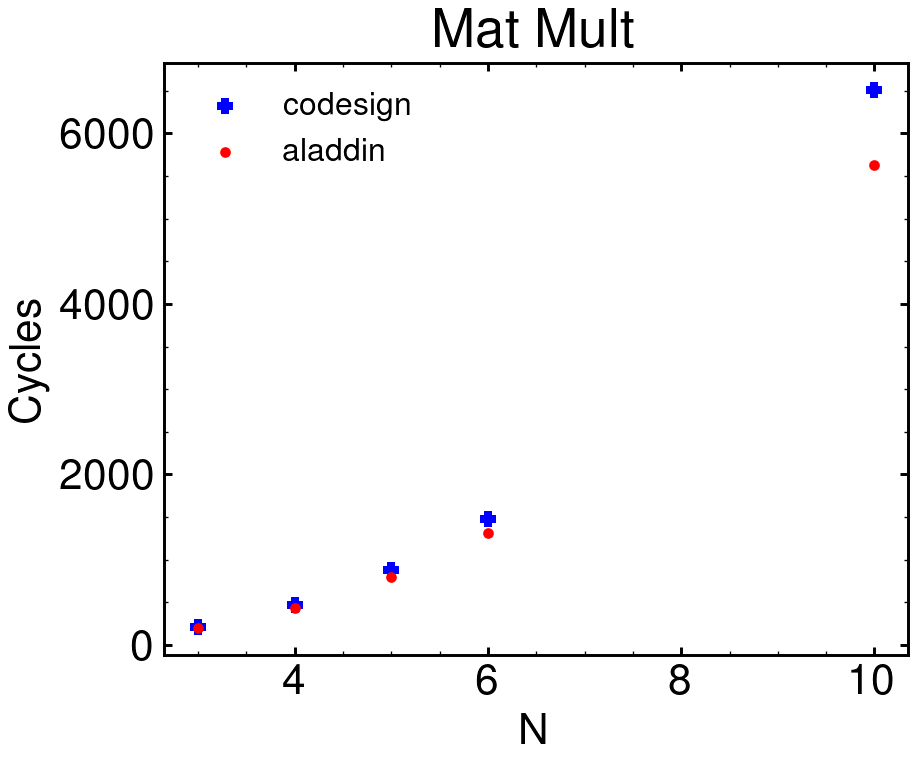

In [18]:
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    # cycles_diff = np.asarray(unrolled_codesign['cycles']) - 9*np.asarray(mat_dim)**3 - 5*np.asarray(mat_dim)**2
    # print(cycles_diff)
    plt.scatter(mat_dim, codesign_post_fix['cycles'], marker='+', label='codesign', c='b')
    # plt.scatter(mat_dim, aladdin['cycles'], marker='.', label='aladdin - no unrolling', c='r', alpha = 0.5)
    plt.scatter(mat_dim, aladdin['cycles'], marker='.', label='aladdin', c='r')
    plt.xlabel('N')
    plt.ylabel('Cycles')
    # plt.yscale('log')
    plt.legend()
    plt.title("Mat Mult")
    plt.show()


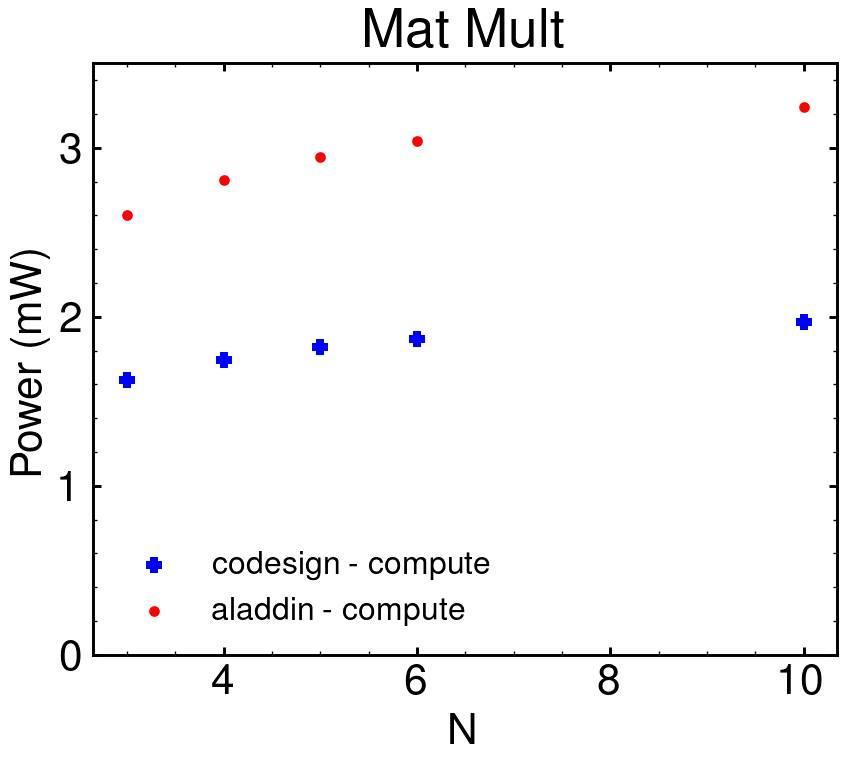

In [22]:
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    plt.scatter(mat_dim, codesign_post_fix['compute power'], marker='+', label='codesign - compute', c='b')
    # plt.scatter(mat_dim, unrolled_codesign['mem power'], marker='^', label='codesign - mem', c='b', alpha = 0.5)

    plt.scatter(mat_dim, aladdin['compute power'], marker='.', label='aladdin - compute', c='r')
    # plt.scatter(mat_dim, unrolled_aladdin['mem power'], marker='^', label='aladdin - mem', c='r', alpha = 0.5)
    plt.xlabel('N')
    plt.ylim(0, 3.5)
    plt.ylabel('Power (mW)')
    # plt.yscale('log')
    plt.legend()
    plt.title("Mat Mult")
    plt.show()

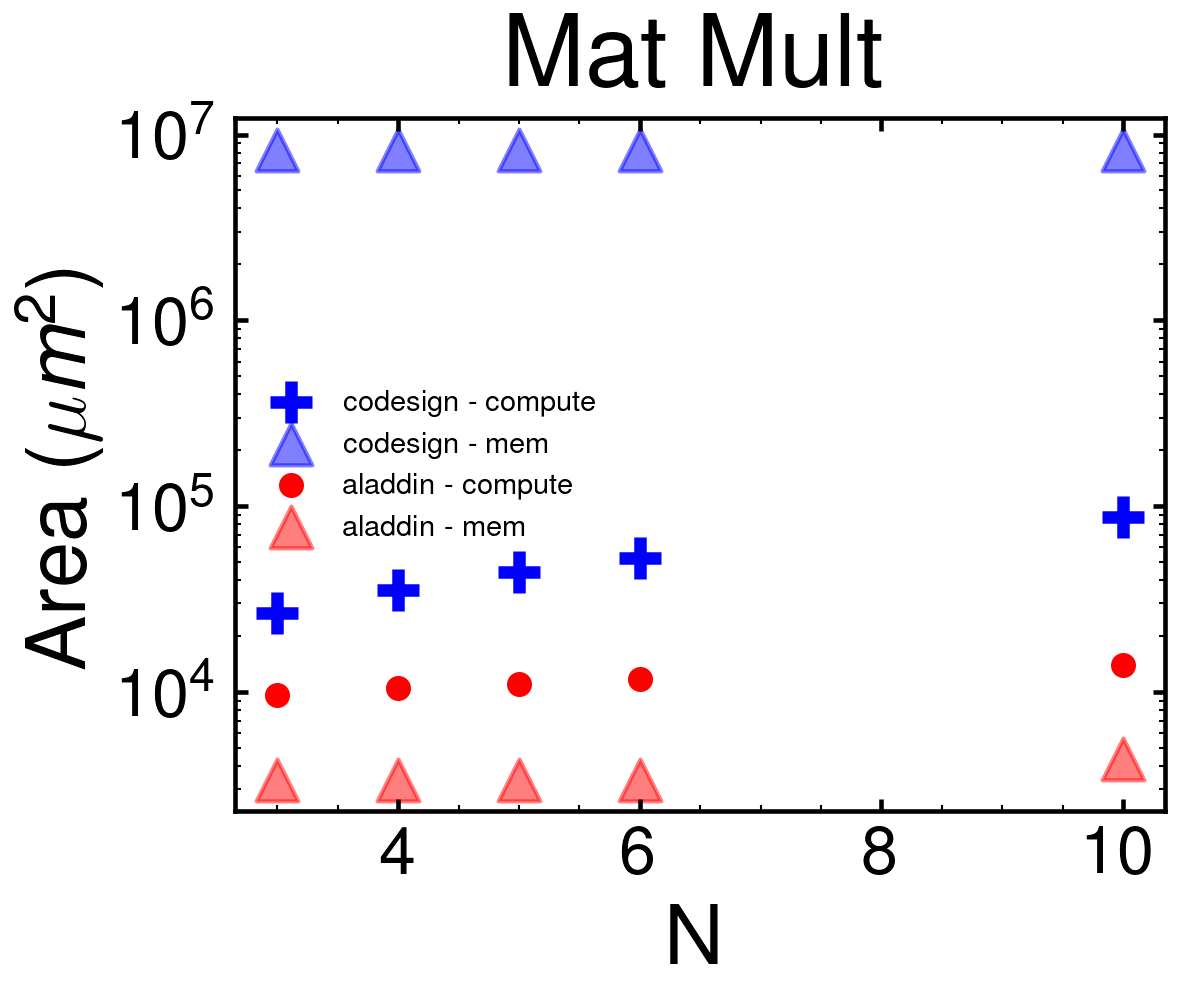

In [86]:
plt.scatter(mat_dim, unrolled_codesign['compute area'], marker='+', label='codesign - compute', c='b')
plt.scatter(mat_dim, unrolled_codesign['mem area'], marker='^', label='codesign - mem', c='b', alpha =0.5)

# total_area = np.array(unrolled_aladdin['compute area']) + np.array(unrolled_aladdin['mem area'])
plt.scatter(mat_dim, unrolled_aladdin['compute area'], marker='.', label='aladdin - compute', c='r')
plt.scatter(mat_dim, unrolled_aladdin['mem area'], marker='^', label='aladdin - mem', c='r', alpha=0.5)
plt.xlabel('N')
plt.ylabel(r'Area ($\mu m^2$)')
plt.yscale('log')
plt.legend()
plt.title("Mat Mult")
plt.show()

## Dict tests

In [2]:
tmp = {'cycles': [338, 59072, 163045, 361536, 0], 
       'avg power': [39249587.42304815 * 1e-6, 158127090.63154665 * 1e-6, 138891920.7748982*1e-6, 123833633.04556464*1e-6, 0.0]
}

for state in tmp:
    for value in state:
        print(value)

c
y
c
l
e
s
a
v
g
 
p
o
w
e
r


## NetworkX hardware representation

#### Gen from old representation (number of elems)

In [10]:
config_name = "aes_arch"
hw = HardwareModel(cfg=config_name)

FileNotFoundError: [Errno 2] No such file or directory: 'architectures/aes_arch.gml'

In [5]:
dict(hw.netlist.nodes.data())

{'Add0': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0},
 'Add1': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 1},
 'Add2': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 2},
 'Add3': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 3},
 'Add4': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 4},
 'Add5': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 5},
 'Add6': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 6},
 'Add7': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 7},
 'Add8': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 8},
 'Add9': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 9},
 'Add10': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 10},
 'Add11': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 11},
 'Add12': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 12},
 'Add13': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 13},
 'Add14': {'type': 'pe', 'function': 'Add', 'in_use': 

In [81]:
hw.netlist.nodes['Regs0']

{'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}

In [120]:
for k,v in dict(hardwareModel.get_nodes_with_func(hw.netlist, "Add")).items():
    print(k)
    print(v)

Add0
{'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}


In [7]:
hw_netlist = nx.DiGraph() # by using directed graphs to properly indicate inputs and outputs.

In [20]:
print(hw.hw_allocated)
hw_allocated = {
    "Regs": 5,
    "And": 1,
    "Or": 0,
    "Add": 1,
    "Sub": 0,
    "Mult": 1,
    "FloorDiv": 0,
    "Mod": 0,
    "LShift": 0,
    "RShift": 0,
    "BitOr": 0,
    "BitXor": 2,
    "BitAnd": 0,
    "Eq": 0,
    "NotEq": 0,
    "Lt": 0,
    "LtE": 0,
    "Gt": 0,
    "GtE": 0,
    "IsNot": 0,
    "USub": 0,
    "UAdd": 0,
    "Not": 0,
    "Invert": 0,
    "Buf": 0,
    "MainMem": 0,
}

{'Regs': 0, 'And': 0, 'Or': 0, 'Add': 0, 'Sub': 0, 'Mult': 0, 'FloorDiv': 0, 'Mod': 0, 'LShift': 0, 'RShift': 0, 'BitOr': 0, 'BitXor': 0, 'BitAnd': 0, 'Eq': 0, 'NotEq': 0, 'Lt': 0, 'LtE': 0, 'Gt': 0, 'GtE': 0, 'IsNot': 0, 'USub': 0, 'UAdd': 0, 'Not': 0, 'Invert': 0, 'Buf': 0, 'MainMem': 0}


In [21]:
for k, v in hw_allocated.items():
    if k == "Regs":
        _type = "memory"
    else:
        _type = "pe"
    for i in range(v):
        hw_netlist.add_node((k + str(i)), type=_type, function=k, in_use=False, idx=i)
    # print(f"k: {k}, v: {v}")
for node in hw_netlist.nodes:
    print(node)
    if "Regs" in node:
        hw_netlist.nodes[node]['size'] = 1
        continue
    for node2 in hw_netlist.nodes:
        if node2 == node:
            continue
        hw_netlist.add_edge(node2, node)
        hw_netlist.add_edge(node, node2)
print(hw_netlist)
print(hw_netlist.nodes.data())
print(list(hw_netlist.edges))

Add0
Add1
Add2
Add3
Add4
Add5
Add6
Add7
Add8
Add9
Add10
Add11
Add12
Add13
Add14
Regs0
Regs1
Regs2
Regs3
Regs4
Regs5
Regs6
Regs7
Regs8
Regs9
Regs10
Regs11
Regs12
Regs13
Regs14
Regs15
Regs16
Regs17
Regs18
Regs19
Regs20
Regs21
Regs22
Regs23
Regs24
Regs25
Regs26
Regs27
Regs28
Regs29
Regs30
Regs31
Regs32
Regs33
Regs34
Regs35
Regs36
Regs37
Regs38
Regs39
Regs40
Regs41
Regs42
Regs43
Regs44
Regs45
Regs46
Regs47
Regs48
Regs49
Regs50
Regs51
Regs52
Regs53
Regs54
Regs55
Regs56
Regs57
Regs58
Regs59
Mult0
Mult1
Mult2
Mult3
Mult4
Mult5
Mult6
Mult7
Mult8
Mult9
Sub0
Sub1
Sub2
Sub3
Sub4
Sub5
Sub6
Sub7
Sub8
Sub9
Sub10
Sub11
Sub12
Sub13
Sub14
FloorDiv0
FloorDiv1
FloorDiv2
FloorDiv3
FloorDiv4
FloorDiv5
FloorDiv6
FloorDiv7
FloorDiv8
FloorDiv9
Eq0
DiGraph with 111 nodes and 8670 edges
[('Add0', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 0}), ('Add1', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 1}), ('Add2', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 2}), ('Add3', {'

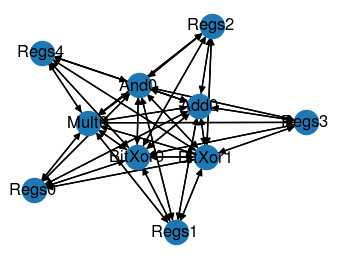

In [22]:
nx.draw(hw_netlist, with_labels=True)
plt.show()

In [23]:
tech_params = yaml.load(open("tech_params.yaml", "r"), Loader=yaml.Loader)

latency = tech_params["latency"][40]

print(hw_netlist.edges.data())
node_data = hw_netlist.nodes.data()
for edge in hw_netlist.edges.data():
    edge[2]["cost"] = latency[node_data[edge[1]]["function"]]

print(hw_netlist.edges.data())

[('Regs0', 'And0', {'cost': 0.06}), ('Regs0', 'Add0', {'cost': 0.94}), ('Regs0', 'Mult0', {'cost': 0.98}), ('Regs0', 'BitXor0', {'cost': 0.06}), ('Regs0', 'BitXor1', {'cost': 0.06}), ('Regs1', 'And0', {'cost': 0.06}), ('Regs1', 'Add0', {'cost': 0.94}), ('Regs1', 'Mult0', {'cost': 0.98}), ('Regs1', 'BitXor0', {'cost': 0.06}), ('Regs1', 'BitXor1', {'cost': 0.06}), ('Regs2', 'And0', {'cost': 0.06}), ('Regs2', 'Add0', {'cost': 0.94}), ('Regs2', 'Mult0', {'cost': 0.98}), ('Regs2', 'BitXor0', {'cost': 0.06}), ('Regs2', 'BitXor1', {'cost': 0.06}), ('Regs3', 'And0', {'cost': 0.06}), ('Regs3', 'Add0', {'cost': 0.94}), ('Regs3', 'Mult0', {'cost': 0.98}), ('Regs3', 'BitXor0', {'cost': 0.06}), ('Regs3', 'BitXor1', {'cost': 0.06}), ('Regs4', 'And0', {'cost': 0.06}), ('Regs4', 'Add0', {'cost': 0.94}), ('Regs4', 'Mult0', {'cost': 0.98}), ('Regs4', 'BitXor0', {'cost': 0.06}), ('Regs4', 'BitXor1', {'cost': 0.06}), ('And0', 'Regs0', {'cost': 2}), ('And0', 'Regs1', {'cost': 2}), ('And0', 'Regs2', {'cost'

In [ ]:
nx.dag_longest_path(hw_netlist, weight='cost')

In [24]:
nx.write_gml(hw_netlist, f'architectures/{config_name}.gml')

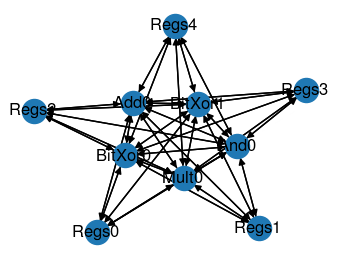

In [25]:
test = nx.read_gml(f"architectures/{config_name}.gml")
nx.draw(test, with_labels=True)
plt.show()

In [ ]:
test.add_nodes_from(
    [
            ("Mem0",
            {
                "type": "mem",
                "function": "MainMem",
                "in_use": False,
                "idx": 0,
                "size": 256,
            }),
            ("Buf0", {"type": "mem", "function": "Buf", "in_use": False, "idx": 0, "size": 1})
        
    ]
)
test.add_edges_from(
    [
        ("Buf0", "Mem0"),
        ("Mem0", "Buf0")
    ])

for node in test.nodes:
    if "Regs" in node:
        test.add_edge(node, "Buf0")
        test.add_edge("Buf0", node)



In [117]:
for node in hw_netlist.nodes:
    for node2 in hw_netlist.nodes:
        if node2 == node:
            continue
        hw_netlist.add_edge(node2, node)
        hw_netlist.add_edge(node, node2)

In [118]:
nx.write_gml(test, f"architectures/{config_name}.gml")

In [138]:
test.add_nodes_from([('Buf0', {'type': 'mem', 'function': 'Buf', 'in_use': False, 'size': 22, 'idx': 0})]) #, ('Buf1', {'type': 'mem', 'function': 'Buf', 'in_use': False, 'size':0, 'idx': 1})])
test.add_edges_from(
    [
        ("Buf0", "Regs0"),
        ("Regs0", "Buf0"),
        ("Buf0", "Regs1"),
        ("Regs1", "Buf0"),
        ("Buf0", "Regs2"),
        ("Regs2", "Buf0"),
        ("Buf0", "Regs3"),
        ("Regs3", "Buf0"),
        ("Buf0", "Regs4"),
        ("Regs4", "Buf0"),
    ]
)

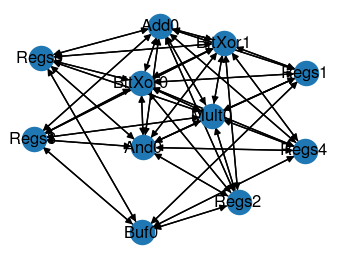

In [27]:
nx.draw(test, with_labels=True)
plt.show()

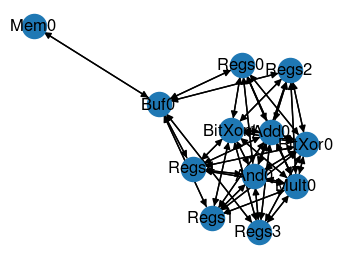

In [28]:
test.add_nodes_from(
    [(
        "Mem0", {"type": "mem", "function": "MainMem", "in_use": False, "idx": 0, 'size':256},
        # "Buf1": {"type": "mem", "function": "Buf", "in_use": False, "idx": 1},
    )]
)
test.add_edges_from(
    [
        ("Buf0", "Mem0"),
        ("Mem0", "Buf0"),
        # ("Buf1", "Mem0"),
        # ("Mem0", "Buf1"),
    ]
)

nx.draw(test, with_labels=True)
plt.show()

In [29]:
nx.write_gml(test, f"architectures/{config_name}.gml")

In [144]:
for node, data in  dict(filter(lambda x: x[1]['function']=='Buf', test.nodes.data())).items():
    print(node)
    print(data)
    edges = test.edges(node)
    print(f"edges: {edges}")
    for edge in edges:
        if test.nodes[edge[1]]['function'] == 'MainMem':
            print(test.nodes[edge[1]])




Buf0
{'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 0, 'size': 0}
edges: [('Buf0', 'Regs0'), ('Buf0', 'Mem0')]
{'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}
Buf1
{'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 1, 'size': 0}
edges: [('Buf1', 'Regs1'), ('Buf1', 'Regs2'), ('Buf1', 'Mem0')]
{'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}


In [ ]:
for node, data in test.nodes.data():
   if data['function'] == "Regs":
      data['size'] = 64

In [140]:
test.nodes.data()

NodeDataView({'Add0': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}, 'Regs0': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}, 'Regs1': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1}, 'Regs2': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2}, 'Mult0': {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}, 'Eq0': {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}, 'Buf0': {'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 0, 'size': 0}, 'Buf1': {'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 1, 'size': 0}, 'Mem0': {'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}})

#### isomorphism

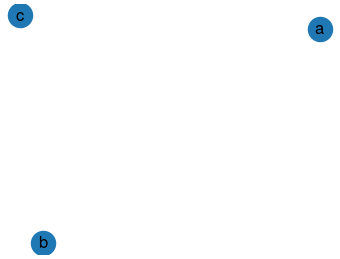

In [127]:
test_graph = nx.DiGraph()
test_graph.add_node("a")
test_graph.add_node("b")
test_graph.add_node("a")
test_graph.add_node("c")
nx.draw(test_graph, with_labels=True)
plt.show()

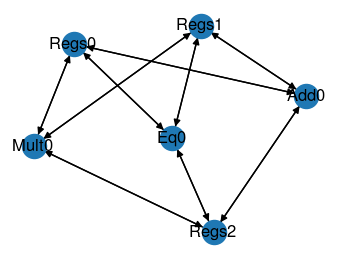

In [107]:
test_2 = test.copy()

test_2.remove_node('Regs0')
nx.draw(test, with_labels=True)
plt.show()

In [108]:
matcher = nx.isomorphism.GraphMatcher(test_graph, test_2)
matcher.subgraph_is_monomorphic()

False

In [21]:
node_data = test.nodes.data()
print(node_data)

[('Add0', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}), ('Regs0', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}), ('Regs1', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1}), ('Regs2', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2}), ('Mult0', {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}), ('Eq0', {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0})]


In [61]:
for k, v in dict(node_data).items():
    if v['function'] == 'Add':
        print(f"k: {k}, v: {v}")
        v['in_use'] = True

k: Add0, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add1, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add2, v: {'type': 'pe', 'function': 'Add', 'in_use': True}


In [62]:
test.nodes['Add1']['type'] = 'test'

In [64]:
for k, v in dict(node_data).items():
    v["in_use"] = False

In [63]:
for k, v in dict(node_data).items():
        print(f"k: {k}, v: {v}")

k: Add0, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add1, v: {'type': 'test', 'function': 'Add', 'in_use': True}
k: Add2, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Regs0, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs1, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs2, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs3, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs4, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs5, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs6, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs7, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs8, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Mult0, v: {'type': 'pe', 'function': 'Mult', 'in_use': False}
k: Mult1, v: {'type': 'pe', 'function': 'Mult', 'in_use': False}
k: Mult2, v: {'type': 'pe', 'function': 'Mult', 'in_use': Fal

In [33]:
config_name = "simple"
test = nx.read_gml(f"architectures/{config_name}.gml")

In [36]:
for node, data in dict(
            filter(lambda x: x[1]["function"] == "Regs", test.nodes.data())
        ).items():  # should only have 1
            print(f"node: {node}, data: {data}")
            test.nodes[node]["size"] = 1

node: Regs0, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}
node: Regs1, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1}
node: Regs2, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2}
node: Regs3, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 3}
node: Regs4, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 4}
node: Regs5, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 5}
node: Regs6, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 6}
node: Regs7, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 7}
node: Regs8, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 8}
node: Regs9, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 9}
node: Regs10, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 10}
node: Regs11, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 11}
node: Regs12, data: {'ty

In [37]:
for node, data in dict(
    filter(lambda x: x[1]["function"] == "Regs", test.nodes.data())
).items():  # should only have 1
    print(f"node: {node}, data: {data}")

node: Regs0, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0, 'size': 1}
node: Regs1, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1, 'size': 1}
node: Regs2, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2, 'size': 1}
node: Regs3, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 3, 'size': 1}
node: Regs4, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 4, 'size': 1}
node: Regs5, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 5, 'size': 1}
node: Regs6, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 6, 'size': 1}
node: Regs7, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 7, 'size': 1}
node: Regs8, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 8, 'size': 1}
node: Regs9, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 9, 'size': 1}
node: Regs10, data: {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1

In [38]:
nx.write_gml(test, f"architectures/{config_name}.gml")

## Iterative Codesign Results

In [5]:
def parse_log_file(log_file):
    forward_edp = []
    inverse_edp = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if "Forward EDP" in line:
            forward_edp.append(float(line.split(":")[-1].strip()))
        if "Inverse EDP" in line:
            inverse_edp.append(float(line.split(":")[-1].strip()))
    return len(forward_edp), forward_edp, inverse_edp

In [6]:
year   = 2024
month  = 6
day    = 16
hour   = 13
minute = 21
sec    = 15
log_dir = f"codesign_log_dir/{year}-{month:02}-{day:02}_{hour:02}-{minute:02}-{sec:02}"

num_iters, forward_edp, inverse_edp = parse_log_file(f"{log_dir}/results.txt")

edps = [val for pair in zip(forward_edp, inverse_edp) for val in pair]

forward: [84.88923887695171, 46.473729851472555, 29.04819106571127, 18.156426385331702, 11.348579756868272, 7.09337049080908, 4.4336747725018615, 2.771246843072747, 1.732156064153185, 1.0826776733694927]
inverse: [11.8397346065462, 29.07305012232, 18.1706563298261, 11.3566602092432, 7.09791263378308, 4.43619539900367, 2.77262212714122, 1.73288883211605, 1.08305552272913, 0.67690970429419]


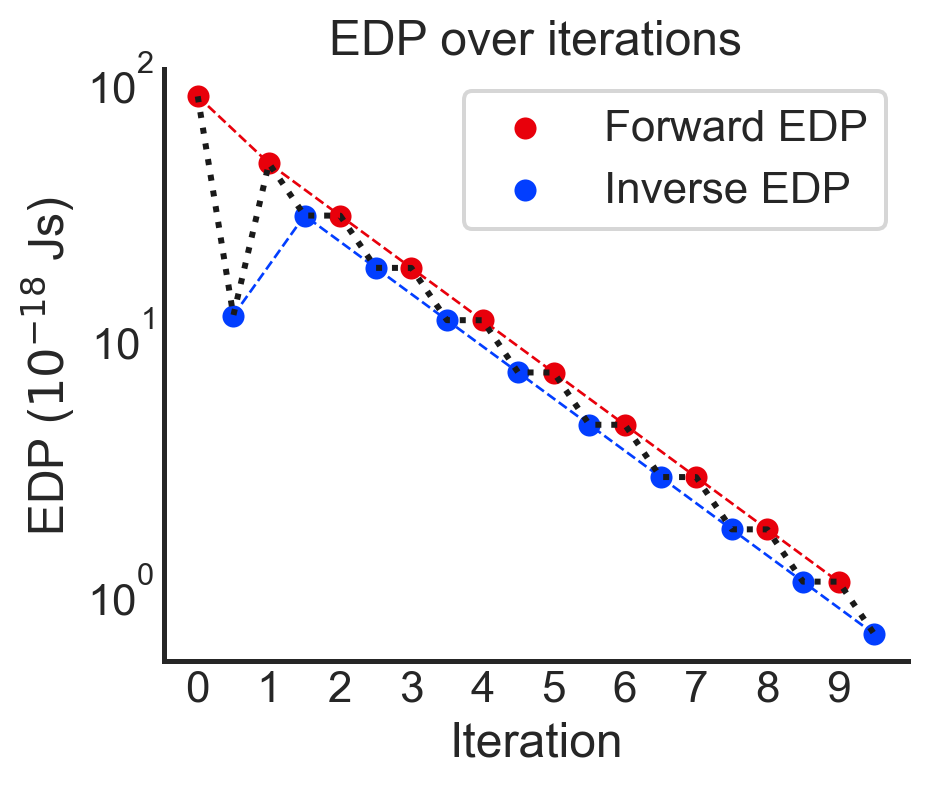

In [8]:
plt.title("EDP over iterations")
c = sns.scatterplot(x=range(num_iters), y=forward_edp, label="Forward EDP", c='r')
sns.lineplot(x=range(num_iters), y=forward_edp, linestyle="dashed", linewidth=1, c='r')
c = sns.scatterplot(x=np.arange(0.5, num_iters+0.5), y=inverse_edp, label="Inverse EDP", c='b')
sns.lineplot(x=np.arange(0.5, num_iters+0.5), y=inverse_edp, linestyle='dashed', linewidth=1, c='b')
sns.lineplot(x=np.arange(0, num_iters, 0.5), y=edps, linestyle='dotted', c= 'k')

sns.despine()

plt.xticks(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel(r"EDP ($10^{-18}$ Js)")
plt.legend()
plt.yscale('log')
plt.show()

In [9]:
rcs = []
for i in range(num_iters):
    rcs.append(yaml.load(open(f"{log_dir}/rcs_{i}.yaml", "r"), Loader=yaml.Loader))

In [10]:
# remove all parameters in rcs that didn't change
keys = list(rcs[0]["Ceff"].keys())

for k in keys:
    val = rcs[0]["Ceff"][k]
    to_pop=True
    for i in range(1, num_iters):
        v = rcs[i]["Ceff"][k]
        to_pop &= (v == val)
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Ceff"].pop(k)
    
    val = rcs[0]["Reff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Reff"][k]
        to_pop &= (v == val)
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Reff"].pop(k)
print(rcs)

[{'Ceff': {'Add': 1.0984611422126203e-07, 'Mult': 7.692715652416966e-05, 'Regs': 6.098800894903056e-10}, 'Reff': {'Add': 19164025.95610083, 'Mult': 111341.72959852389, 'Not': 146027331.86219463, 'Regs': 558078480.6177291}, 'other': {'BufL': 1.47098, 'BufPpass': 6.348340000000001e-08, 'BufReadEact': 2.2885100000000002e-10, 'BufWriteEact': 3.2773400000000005e-10, 'MemPpass': 5.829407761161014e-08, 'MemReadEact': 1.2535300000000001e-09, 'MemReadL': 4.16988, 'MemWriteEact': 2.795e-09, 'MemWriteL': 4.16988, 'OffChipIOL': 1.25e-09, 'OffChipIOPact': 1.50636, 'V_dd': 0.9925203478685869}}, {'Ceff': {'Add': 9.90410534979389e-08, 'Mult': 7.559770788518309e-05, 'Regs': 6.006044470381767e-10}, 'Reff': {'Add': 17278993.269309588, 'Mult': 109551.4457700487, 'Not': 145445186.07333952, 'Regs': 549590704.8863997}, 'other': {'BufL': 1.47098, 'BufPpass': 6.348340000000001e-08, 'BufReadEact': 2.2885100000000002e-10, 'BufWriteEact': 3.2773400000000005e-10, 'MemPpass': 5.6338546741039254e-08, 'MemReadEact': 

In [15]:
rc_df = pd.DataFrame(rcs)
print(rc_df.columns)

Index(['Ceff', 'Reff', 'other'], dtype='object')


In [13]:
def plot_from_rcs(k1, k2s, num_iters, rcs, title='', ylabel = '', labels=[]):
    if type(k2s) is not list:
        k2s = [k2s]
    for i in range(len(k2s)):
        k2 = k2s[i]

        val = np.asarray(list(map(lambda x: float(x[k1][k2]), rcs)))
        # name = f"{k1}_{k2}" if k1 != "other" else k2
        val = val/val[0]
        if len(labels) != 0:
            lbl = labels[i]
        else: lbl = k2
        c = sns.scatterplot(x=range(num_iters), y=val, label=lbl)
        sns.lineplot(x=range(num_iters), y=val, linestyle='dotted', markers=True) #c= c.get_facecolor())
    if title == '':
        title = f"{k1} over iterations"
    else:
        title += " over iterations"
    plt.title(title)
    sns.despine()

    # for i in range(num_iters):
    #     plt.scatter(rcs[i][k1], rcs[i][k2], label=f"iter {i}")
    plt.xlabel("Iteration")
    if ylabel == '':
        ylabel = f"{k1} (normalized)"
    else:
        ylabel += " (normalized)"
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

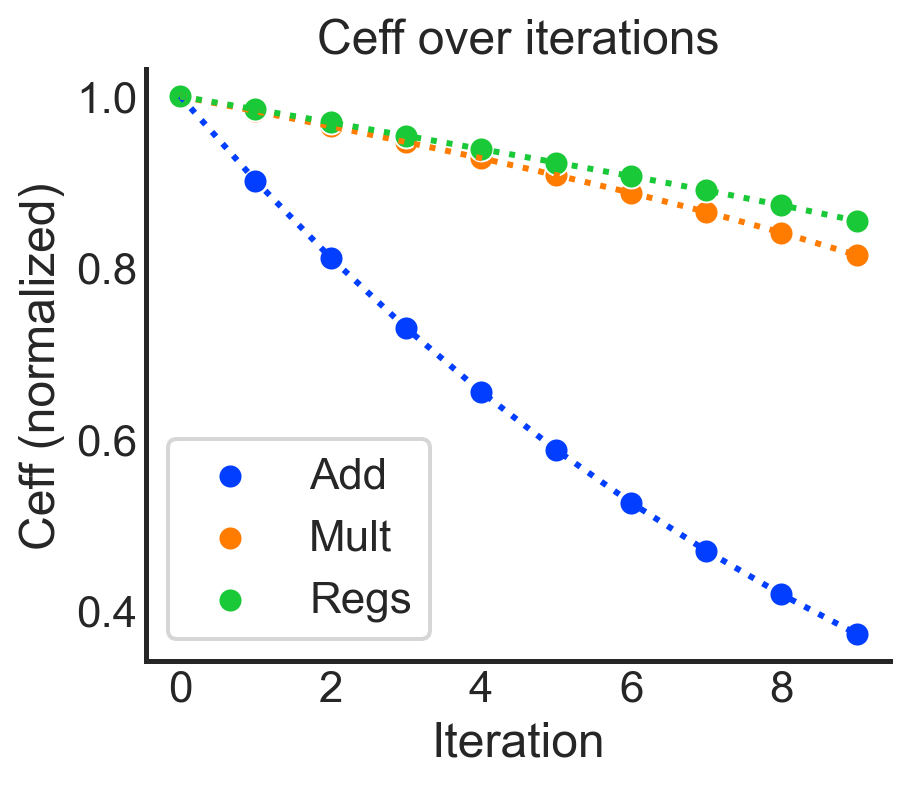

In [14]:
k1 = "Ceff"
k2s = list(rcs[0][k1].keys())

plot_from_rcs(k1, k2s, num_iters, rcs)

/var/folders/pb/xkf_1m6d4_b_x6511mct3t3r0000gn/T/ipykernel_53325/3077986414.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


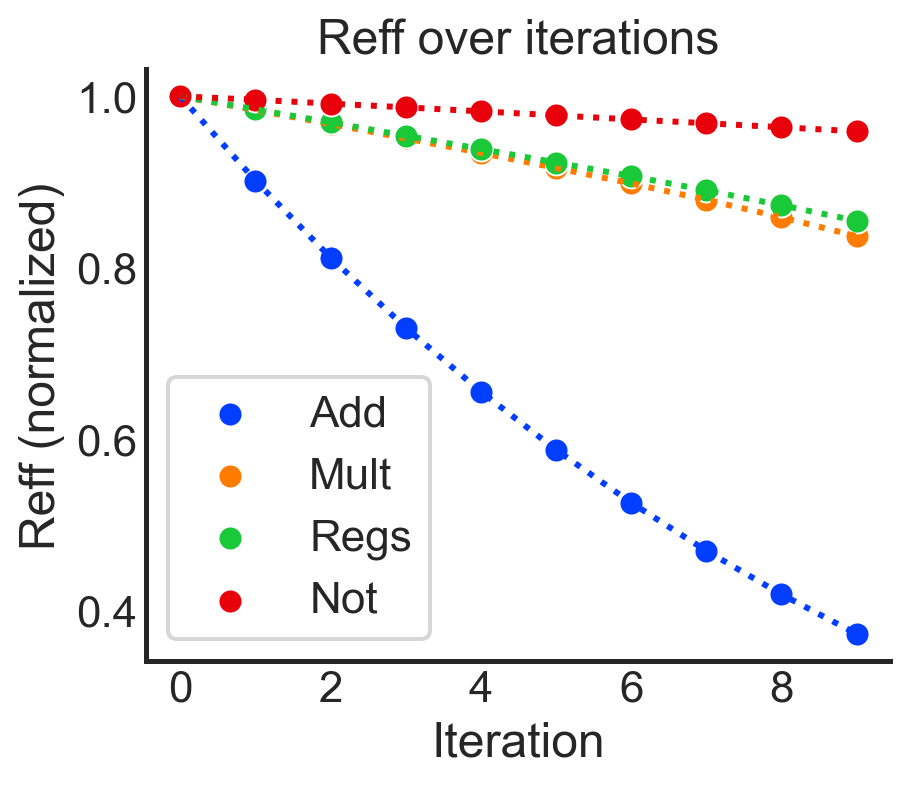

In [16]:
k1 = "Reff"
k2s = list(rcs[0][k1].keys())
tmp_idx = k2s.index("Not")
k2s.pop(tmp_idx)
k2s.append("Not")

with pd.option_context('mode.use_inf_as_na', True):
    plot_from_rcs(k1, k2s, num_iters, rcs)

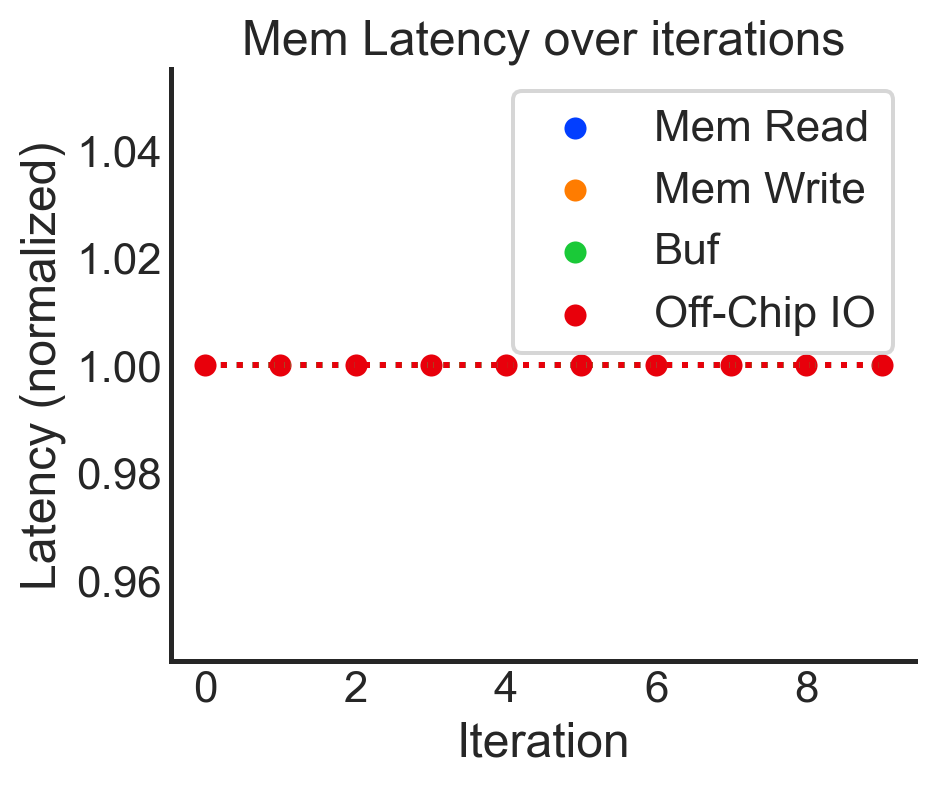

In [17]:
k1 = "other"
k2s = ["MemReadL", "MemWriteL", "BufL", "OffChipIOL"]
labels = ["Mem Read", "Mem Write", "Buf", "Off-Chip IO"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Latency", "Latency", labels)

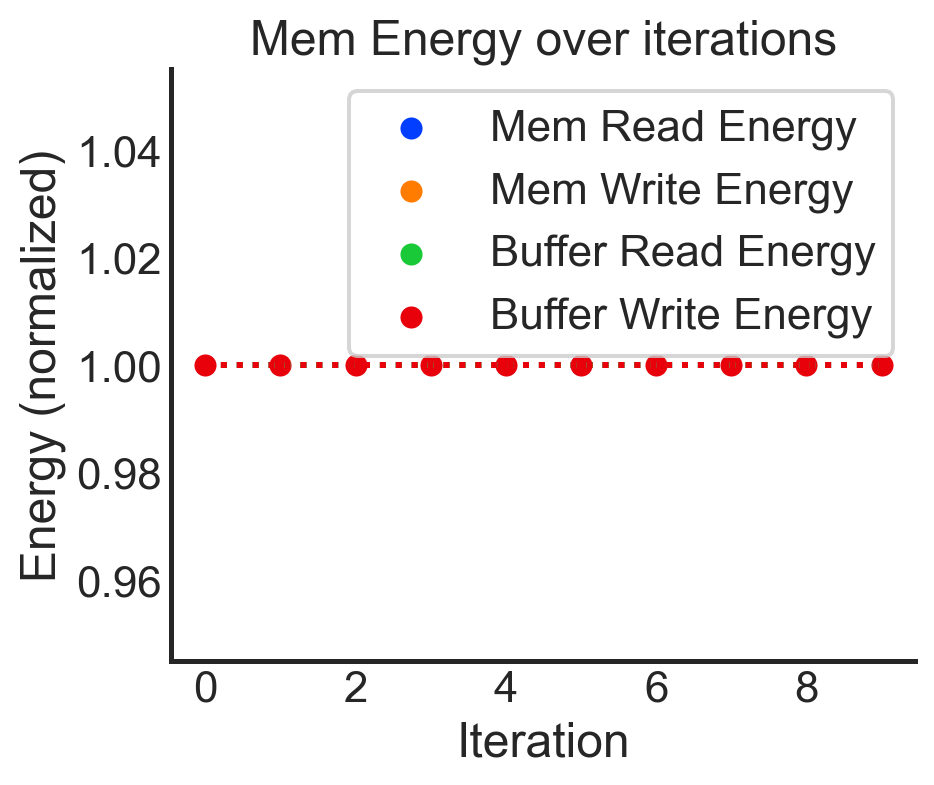

In [18]:
k1 = "other"
k2s = ["MemReadEact", "MemWriteEact", "BufReadEact", "BufWriteEact"] #"MemPpass"]
labels = ["Mem Read Energy", "Mem Write Energy", "Buffer Read Energy", "Buffer Write Energy"]# "Passive"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Energy", "Energy", labels)

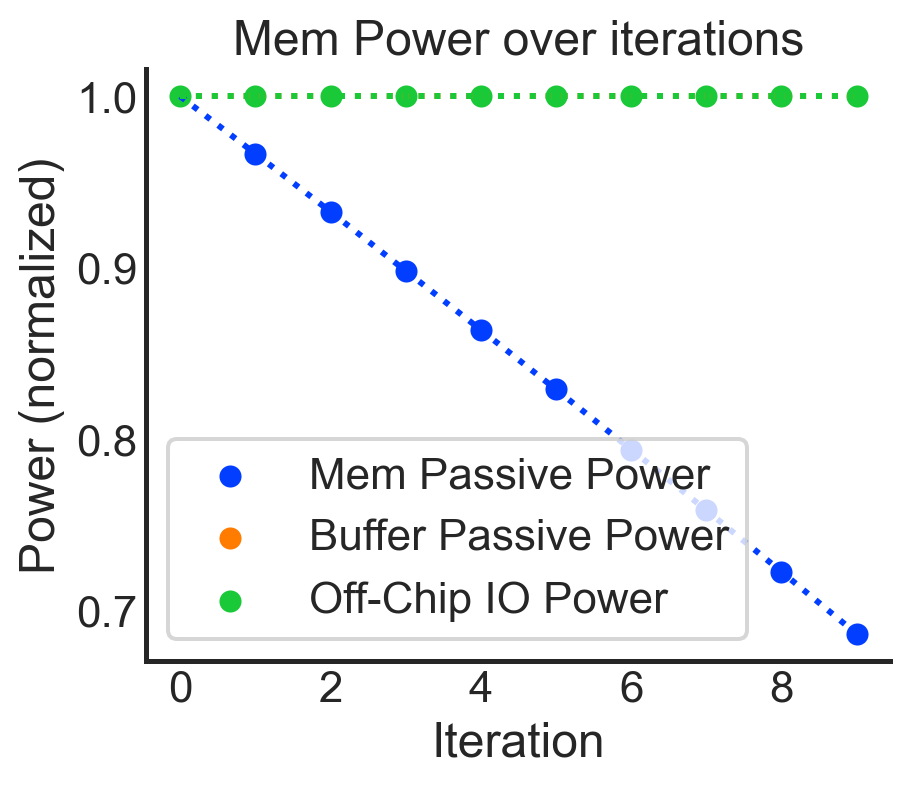

In [19]:
k1 = "other"
k2s = ["MemPpass", "BufPpass", "OffChipIOPact"]
labels = [
    "Mem Passive Power",
    "Buffer Passive Power",
    "Off-Chip IO Power"
] 

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Power", "Power", labels)

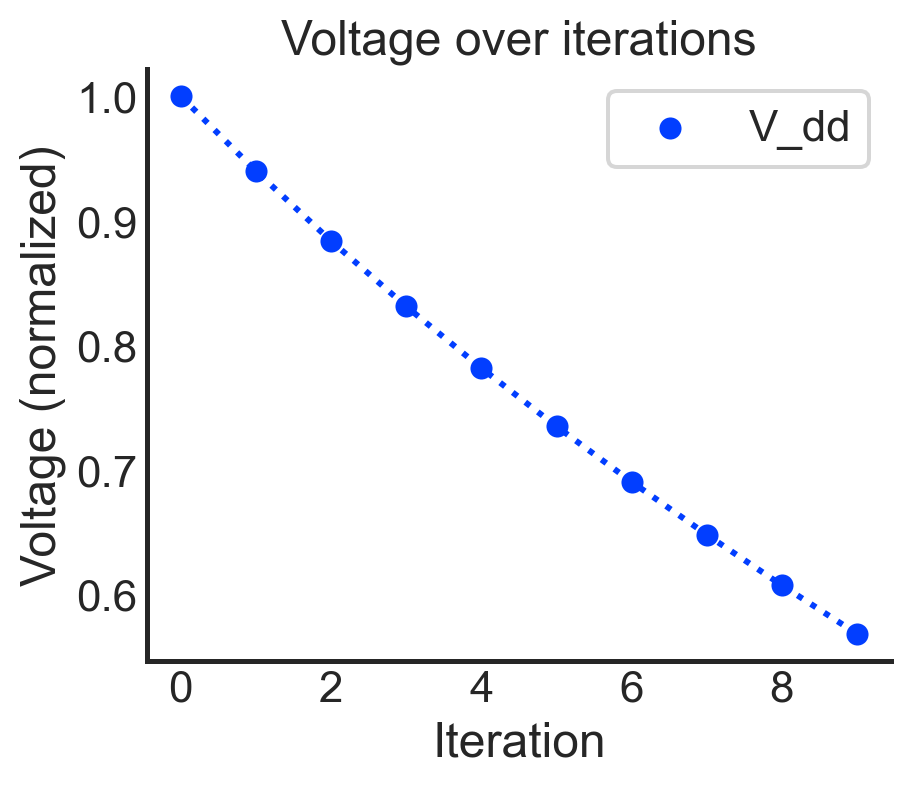

In [20]:
k1 = "other"
k2s = ["V_dd"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

In [ ]:
# DEPRECATED
k1 = "other"
k2s = ["f"]
# labels = ["Read active", "Write active", "Passive"]
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plt.ylim(0.5, 1.02)
    plot_from_rcs(k1, k2s, num_iters, rcs, "Frequency", "Frequency")

## Topo sort inverse

In [250]:
benchmark = "benchmarks/models/matmult.py"

simulator = ConcreteSimulator()

hw = HardwareModel(cfg="aladdin_const_with_mem")
hardwareModel.un_allocate_all_in_use_elements(hw.netlist)

cfg, cfg_node_to_hw_map = simulator.simulator_prep(benchmark, hw.latency)

hw.init_memory(
    sim_util.find_nearest_power_2(simulator.memory_needed),
    sim_util.find_nearest_power_2(simulator.nvm_memory_needed),
)

memory needed: 636 bytes
nvm memory needed: 0 bytes


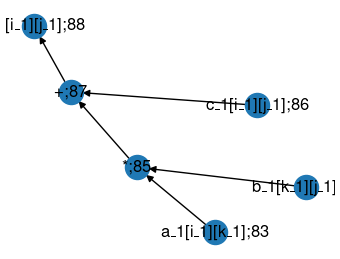

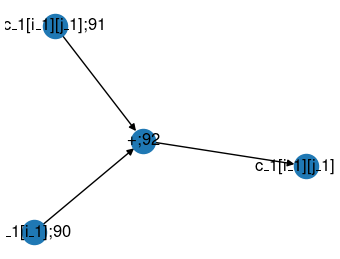

In [20]:
for k, dfg in cfg_node_to_hw_map.items():
    if nx.is_empty(dfg):
        continue
    nx.draw(dfg, with_labels=True)
    plt.show()

top of compose; length of data path: 24
done composing computation graph


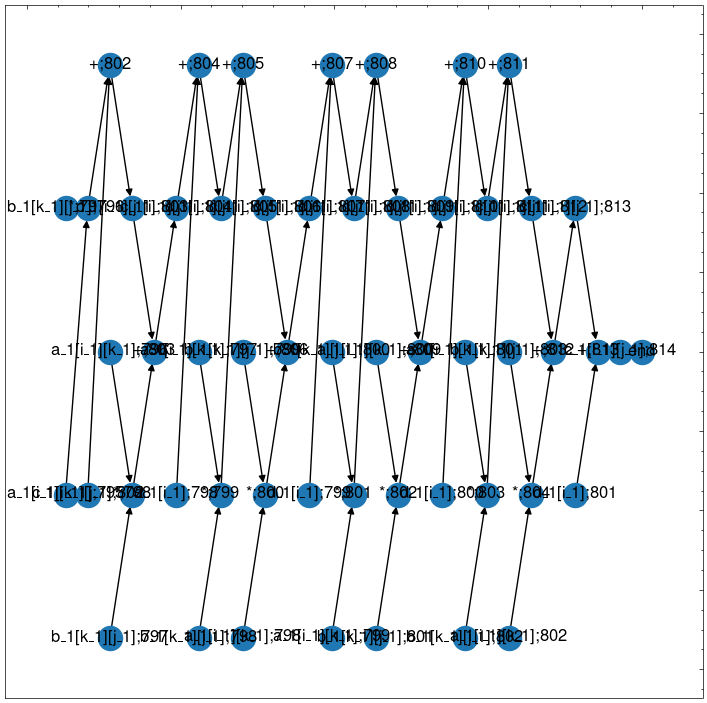

In [253]:
computation_dfg = simulator.compose_entire_computation_graph(
    cfg_node_to_hw_map, plot=True
)

#### miscllaneous

In [ ]:
for k, v in cfg_node_to_hw_map.items():
    if not nx.is_empty(v):
        nx.draw(v, with_labels=True)
        plt.show()

In [6]:
reversed_comp_graph = nx.reverse(computation_dfg)

In [ ]:
# regular topo sort

for k,v in cfg_node_to_hw_map.items():
    if nx.is_empty(v):
        continue
    for layer, nodes in enumerate(nx.topological_generations(v)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            v.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(v, subset_key="layer")

    fig, ax = plt.subplots()
    nx.draw_networkx(v, pos=pos, ax=ax)
    plt.show()

In [ ]:
for k,v in cfg_node_to_hw_map.items():
    if nx.is_empty(v):
        continue
    rev = nx.reverse(v)
    for layer, nodes in enumerate(nx.topological_generations(rev)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            v.nodes[node]["layer"] = -1*layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(v, subset_key="layer")

    fig, ax = plt.subplots()
    nx.draw_networkx(v, pos=pos, ax=ax)
    plt.show()

[['c_1[i_1][j_1];146'], ['+;145'], ['c_1[i_1][j_1];145', 'd_1[i_1];140'], ['+;144'], ['c_1[i_1][j_1];144', '*;139'], ['+;143', 'a_1[i_1][k_1];137', 'b_1[k_1][j_1];138'], ['c_1[i_1][j_1];143', '*;138'], ['+;142', 'b_1[k_1][j_1];137', 'a_1[i_1][k_1];136'], ['c_1[i_1][j_1];142', 'd_1[i_1];139'], ['+;141'], ['c_1[i_1][j_1];139', '*;137'], ['+;138', 'b_1[k_1][j_1];136', 'a_1[i_1][k_1];135'], ['c_1[i_1][j_1];141', '*;136'], ['+;140', 'a_1[i_1][k_1];134', 'b_1[k_1][j_1];135'], ['c_1[i_1][j_1];138', 'd_1[i_1];138'], ['+;137'], ['c_1[i_1][j_1];137', '*;135'], ['+;136', 'a_1[i_1][k_1];133', 'b_1[k_1][j_1];134'], ['c_1[i_1][j_1];140', '*;134'], ['+;139', 'b_1[k_1][j_1];133', 'a_1[i_1][k_1];132'], ['c_1[i_1][j_1];136', 'd_1[i_1];137'], ['+;135'], ['c_1[i_1][j_1];135', '*;133'], ['+;134', 'b_1[k_1][j_1];132', 'a_1[i_1][k_1];131'], ['c_1[i_1][j_1];133', '*;132'], ['a_1[i_1][k_1];130', 'b_1[k_1][j_1];131'], ['Buf0', 'Buf1'], ['Mem0', 'Mem1']]


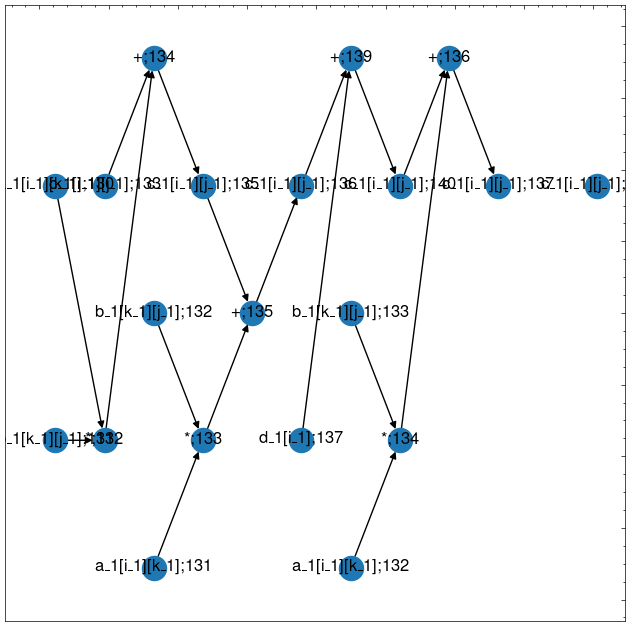

In [28]:
rev = nx.reverse(computation_dfg)
gens = list(nx.topological_generations(rev))
print(gens)
rev_gens = reversed(gens)
print(rev_gens)

for layer, nodes in enumerate(rev_gens):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    # print(layer)
    for node in nodes:
        computation_dfg.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(computation_dfg, subset_key="layer")

len(computation_dfg.nodes)
sub_nodes = list(computation_dfg.nodes)[0:20]
sub_comp_graph = computation_dfg.subgraph(sub_nodes)

fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx(sub_comp_graph, pos=pos, ax=ax)
plt.show()

#### end misc

In [236]:
hw_netlist = nx.DiGraph()

hw_allocated = {
    "Regs": 2,
    "And": 0,
    "Or": 0,
    "Add": 1,
    "Sub": 0,
    "Mult": 2,
    "FloorDiv": 0,
    "Mod": 0,
    "LShift": 0,
    "RShift": 0,
    "BitOr": 0,
    "BitXor": 0,
    "BitAnd": 0,
    "Eq": 0,
    "NotEq": 0,
    "Lt": 0,
    "LtE": 0,
    "Gt": 0,
    "GtE": 0,
    "IsNot": 0,
    "USub": 0,
    "UAdd": 0,
    "Not": 0,
    "Invert": 0,
    "Buf": 0,
    "MainMem": 0,
}

for k, v in hw_allocated.items():
    if k == "Regs":
        type = "memory"
    else:
        type = "pe"
    for i in range(v):
        hw_netlist.add_node((k + str(i)), type=type, function=k, in_use=False, idx=i)
    # print(f"k: {k}, v: {v}")
for node in hw_netlist.nodes:
    print(node)
    if "Regs" in node: # all nodes that are not regs
        continue
    for node2 in hw_netlist.nodes:
        if node2 == node or "Regs" not in node2: # all nodes that are regs and not self
            continue
        hw_netlist.add_edge(node2, node)
        hw_netlist.add_edge(node, node2)

hw_netlist.add_edges_from([("Mult0", "Add0"), ("Mult1", "Add0"), ("Mult0", "Mult1")])

print(hw_netlist)
print(hw_netlist.nodes.data())
print(list(hw_netlist.edges))



Regs0
Regs1
Add0
Mult0
Mult1
DiGraph with 5 nodes and 15 edges
[('Regs0', {'type': 'memory', 'function': 'Regs', 'in_use': False, 'idx': 0}), ('Regs1', {'type': 'memory', 'function': 'Regs', 'in_use': False, 'idx': 1}), ('Add0', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 0}), ('Mult0', {'type': 'pe', 'function': 'Mult', 'in_use': False, 'idx': 0}), ('Mult1', {'type': 'pe', 'function': 'Mult', 'in_use': False, 'idx': 1})]
[('Regs0', 'Add0'), ('Regs0', 'Mult0'), ('Regs0', 'Mult1'), ('Regs1', 'Add0'), ('Regs1', 'Mult0'), ('Regs1', 'Mult1'), ('Add0', 'Regs0'), ('Add0', 'Regs1'), ('Mult0', 'Regs0'), ('Mult0', 'Regs1'), ('Mult0', 'Add0'), ('Mult0', 'Mult1'), ('Mult1', 'Regs0'), ('Mult1', 'Regs1'), ('Mult1', 'Add0')]


In [243]:
computation_dfg = nx.DiGraph()
computation_dfg.add_nodes_from(
    [
        ("a1", {"function": "Regs", "cost": 1, "allocation": None}),
        ("a2", {"function": "Regs", "cost": 1, "allocation": None}),
        ("b1", {"function": "Regs", "cost": 1, "allocation": None}),
        ("b2", {"function": "Regs", "cost": 1, "allocation": None}),
        ("mult1", {"function": "Mult", "cost": 1, "allocation": None}),
        ("mult2", {"function": "Mult", "cost": 1, "allocation": None}),
        ("add1", {"function": "Add", "cost": 1, "allocation": None}),
    ]
)
computation_dfg.add_edges_from(
    [
        ("a1", "mult1"),
        ("a2", "mult1"),
        ("b1", "mult2"),
        ("b2", "mult2"),
        ("mult1", "add1"),
        ("mult2", "add1"),
    ])

In [244]:
# schedule the computation graph

hw_element_counts = {}
for func in hardwareModel.get_unique_funcs(hw_netlist):
    hw_element_counts[func] = hardwareModel.num_nodes_with_func(hw_netlist, func)

computation_dfg_with_stalls = computation_dfg.copy()

schedule.schedule(computation_dfg_with_stalls, hw_element_counts)


# available_hw_counts = hw_element_counts.copy()
# available_hw_counts["stall"] = np.inf

# pushed = []

# # going through the computation graph from the end to the beginning
# generations = list(nx.topological_generations(nx.reverse(computation_dfg)))
# layer = 0
# while layer < len(generations) or len(pushed) != 0:
#     if layer == len(generations):
#         generation = []
#     else:
#         generation = generations[layer]
#     full_gen = generation + pushed
#     pushed = []
#     print(f"full gen before remove horizontal: {full_gen}")
#     for node in full_gen:
#         computation_dfg.nodes[node]["layer"] = -layer
#         out_nodes = list(map(lambda x: x[1], computation_dfg.out_edges(node)))
#         intersect = set(out_nodes).intersection(set(full_gen))
#         print(f"out_nodes: {out_nodes}, intersect: {intersect}")
#         if intersect:
#             print(f"found horizontal edge: {intersect} for node {node}; pushing node up one layer.")
#             pushed.append(node)
#     full_gen = [item for item in full_gen if item not in pushed] # remove all at end 
#     print(f"full gen after remove horizontal: {full_gen}")

#     nodes = list(filter(lambda x: x[0] in full_gen, computation_dfg.nodes.data()))
#     # print(f"nodes: {nodes}")
#     funcs, counts = np.unique(list(map(lambda x: x[1]["function"], nodes)), return_counts=True)

#     for func, count in zip(funcs, counts):
#         # print(f"func: {func}, count: {count}")
#         if count > available_hw_counts[func]:
#             func_nodes = list(filter(lambda x: x[1]["function"] == func, nodes))
#             diff = count - available_hw_counts[func]
#             print(f"not enough resources for {func}; diff: {diff}")

#             start_idx = available_hw_counts[func]
#             for idx in range(start_idx, count):
#                 # print(f"idx: {idx}; node: {func_nodes[idx][0]}")
#                 # an out edge in comp_dfg is an in_edge in the reversed_graph
#                 in_edges = list(computation_dfg.out_edges(func_nodes[idx][0]))
#                 # this should never be greater than length 1.
#                 # print(f"in_edges: {in_edges}")
#                 assert len(in_edges) == 1
#                 stall_name = f"stall_{layer}_{idx}_{func}_{rng.integers(0,100)}"
#                 computation_dfg.add_node(stall_name, function="stall", cost=func_nodes[idx][1]["cost"], layer = -1*layer)
#                 computation_dfg.remove_edges_from(in_edges)
#                 computation_dfg.add_edges_from([(stall_name, in_edges[0][1]), (func_nodes[idx][0], stall_name)])
#                 computation_dfg.nodes[func_nodes[idx][0]]["layer"] = -1*(layer + 1)
#                 pushed.append(func_nodes[idx][0])
#                 print(f"in edges after push: {computation_dfg.out_edges(func_nodes[idx][0])}")
#                 print(f"edges for the stall: {computation_dfg.out_edges(stall_name)}, {computation_dfg.in_edges(stall_name)}")
#             print(f"pushed: {pushed}")
#         layer = min(layer + 1, len(generations))

# # do this again to make sure layer numbers are right.
# for layer, generation in enumerate(
#     list(nx.topological_generations(nx.reverse(computation_dfg)))):
#     for node in generation:
#         computation_dfg.nodes[node]["layer"] = -layer

nodes: [('c_1[i_1][j_1];791', {'function': 'Regs', 'idx': '791', 'cost': 2, 'layer': 1}), ('b_1[k_1][j_1];789', {'function': 'Regs', 'idx': '789', 'cost': 2, 'layer': 0}), ('a_1[i_1][k_1];788', {'function': 'Regs', 'idx': '788', 'cost': 2, 'layer': 0}), ('+;792', {'function': 'Add', 'idx': '792', 'cost': 0.94, 'layer': 2}), ('*;790', {'function': 'Mult', 'idx': '790', 'cost': 0.98, 'layer': 1}), ('c_1[i_1][j_1];793', {'function': 'Regs', 'idx': '791', 'cost': 2, 'layer': 3}), ('c_1[i_1][j_1];794', {'function': 'Regs', 'idx': '796', 'cost': 2, 'layer': 5}), ('*;791', {'function': 'Mult', 'idx': '790', 'cost': 0.98, 'layer': 3}), ('+;793', {'function': 'Add', 'idx': '792', 'cost': 0.94, 'layer': 4}), ('a_1[i_1][k_1];789', {'function': 'Regs', 'idx': '788', 'cost': 2, 'layer': 2}), ('b_1[k_1][j_1];790', {'function': 'Regs', 'idx': '789', 'cost': 2, 'layer': 2}), ('d_1[i_1];795', {'function': 'Regs', 'idx': '795', 'cost': 2, 'layer': 5}), ('+;797', {'function': 'Add', 'idx': '797', 'cost':

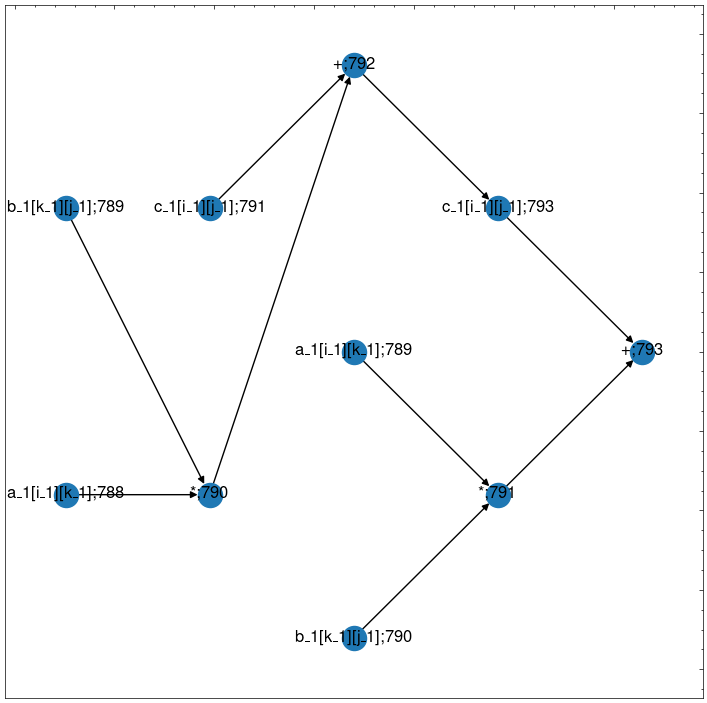

In [252]:
rev = nx.reverse(computation_dfg)
gens = list(nx.topological_generations(rev))
# print(gens)
rev_gens = reversed(gens)

for layer, nodes in enumerate(rev_gens):
    for node in nodes:
        computation_dfg.nodes[node]["layer"] = layer

# print(f"nodes: {computation_dfg.nodes.data(True)}")

pos = nx.multipartite_layout(computation_dfg, subset_key="layer")

print(f"nodes: {computation_dfg.nodes.data(True)}")
layer_start = 0
layer_size = 5
sub_nodes = list(
    filter(
        lambda x: computation_dfg.nodes[x]["layer"] >= layer_start
        and computation_dfg.nodes[x]["layer"] < layer_start + layer_size,
        computation_dfg.nodes,
    )
)
print(f"sub nodes: {sub_nodes}")
sub_comp_graph = computation_dfg.subgraph(sub_nodes)

fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(sub_comp_graph, pos=pos, ax=ax)
plt.show()

In [245]:
# binding
hardwareModel.un_allocate_all_in_use_elements(hw_netlist)
# start from the bottom again.
for layer, generation in enumerate(list(nx.topological_generations(nx.reverse(computation_dfg_with_stalls)))):
    temp_C = nx.DiGraph()
    for node in generation:
        if computation_dfg_with_stalls.nodes[node]["function"] == "stall":
            continue
        temp_C.add_nodes_from([(node, computation_dfg_with_stalls.nodes[node])])
        for child in computation_dfg_with_stalls.successors(node):
            if child not in temp_C.nodes and "stall" not in child:
                temp_C.add_nodes_from([(child, computation_dfg_with_stalls.nodes[child])])
            temp_C.add_edge(node, child)
        for parent in computation_dfg_with_stalls.predecessors(node):
            if parent not in temp_C.nodes and "stall" not in parent:
                temp_C.add_nodes_from([(parent, computation_dfg_with_stalls.nodes[parent])])
            temp_C.add_edge(parent, node)            

    dgm = nx.isomorphism.DiGraphMatcher(
        hw_netlist,
        temp_C,
        node_match=lambda n1, n2: n1["function"] == n2["function"]
        or n2["function"] == None  # hw_graph can have no ops
        or n2["function"] == "stall",
    )

    if dgm.subgraph_is_monomorphic():
        print(f"all good")
    else:
        print(f"not all good")


    print(f"nodes: {temp_C.nodes.data(data='allocation')}")
    print(f"edges: {temp_C.edges}")

all good
nodes: [('add1', None), ('mult1', None), ('mult2', None)]
edges: [('mult1', 'add1'), ('mult2', 'add1')]
not all good
nodes: [('mult1', None), ('add1', None), ('a1', None), ('a2', None), ('mult2', None), ('stall_2_2_Regs_59', None), ('stall_2_3_Regs_49', None)]
edges: [('mult1', 'add1'), ('a1', 'mult1'), ('a2', 'mult1'), ('mult2', 'add1'), ('stall_2_2_Regs_59', 'mult2'), ('stall_2_3_Regs_49', 'mult2')]
all good
nodes: [('a1', None), ('mult1', None), ('a2', None)]
edges: [('a1', 'mult1'), ('a2', 'mult1')]


KeyError: 'function'

In [66]:
# simulate

rev = nx.reverse(computation_dfg)
gens = list(nx.topological_generations(rev))
rev_gens = reversed(gens)

for layer, generation in enumerate(rev_gens):

    temp_c = sim_util.verify_can_execute(computation_dfg, hw.netlist, generation=generation)
    if temp_c is None:
        raise Exception(
            "hardware specification insufficient to run program"
        )
    print(f"nodes: {temp_c.nodes.data(data='allocation')}")
    print(f"edges: {temp_c.edges}")

    # how to deal with the mallocs and frees in this new case? 
    # Explicit nodes in the dfg?
    '''mallocs = pattern_mallocs[idx]
    frees = pattern_frees[idx]
    for malloc in mallocs:
        self.process_memory_operation(
            malloc,
            list(hardwareModel.get_memory_node(hw.netlist).values())[0][
                "memory_module"
            ],
        )  '''
    
    # in localize memory we need to account for a mem bw constraint and so can only add as many mem_reads/writes
    # as the mem bw allows.
    sim_util.localize_memory(hw, temp_c, computation_dfg)
    # print(f"nodes: {temp_c.nodes.data(True)}")

nodes: [('a_1[i_1][k_1];459', 'Regs0'), ('*;461', 'Mult0'), ('b_1[k_1][j_1];460', 'Regs1')]
edges: [('a_1[i_1][k_1];459', '*;461'), ('b_1[k_1][j_1];460', '*;461')]
nodes: [('c_1[i_1][j_1];462', 'Regs0'), ('+;463', 'Add0'), ('*;461', 'Mult0')]
edges: [('c_1[i_1][j_1];462', '+;463'), ('*;461', '+;463')]
nodes: [('+;463', 'Add0'), ('c_1[i_1][j_1];464', 'Regs0'), ('b_1[k_1][j_1];461', 'Regs2'), ('*;462', 'Mult0'), ('a_1[i_1][k_1];460', 'Regs1')]
edges: [('+;463', 'c_1[i_1][j_1];464'), ('b_1[k_1][j_1];461', '*;462'), ('a_1[i_1][k_1];460', '*;462')]
nodes: [('c_1[i_1][j_1];464', 'Regs0'), ('+;464', 'Add0'), ('*;462', 'Mult0')]
edges: [('c_1[i_1][j_1];464', '+;464'), ('*;462', '+;464')]
nodes: [('+;464', 'Add0'), ('c_1[i_1][j_1];465', 'Regs0')]
edges: [('+;464', 'c_1[i_1][j_1];465')]
nodes: [('c_1[i_1][j_1];465', 'Regs0'), ('+;468', 'Add0'), ('d_1[i_1];466', 'Regs1')]
edges: [('c_1[i_1][j_1];465', '+;468'), ('d_1[i_1];466', '+;468')]
nodes: [('+;468', 'Add0'), ('c_1[i_1][j_1];469', 'Regs0'), 

[['c_1[i_1][j_1];381'], ['+;380', 'Buf31'], ['c_1[i_1][j_1];380', 'd_1[i_1];375', 'Mem31'], ['+;379', 'Buf30'], ['c_1[i_1][j_1];379', '*;374', 'Mem30'], ['+;378', 'Buf29', 'b_1[k_1][j_1];373', 'a_1[i_1][k_1];372'], ['c_1[i_1][j_1];378', '*;373', 'Mem29', 'Buf27', 'Buf28'], ['+;377', 'Buf23', 'Buf26', 'a_1[i_1][k_1];371', 'b_1[k_1][j_1];372', 'Mem27', 'Mem28'], ['c_1[i_1][j_1];377', 'd_1[i_1];374', 'Mem23', 'Mem26', 'Buf24', 'Buf25'], ['+;376', 'Buf22', 'Mem24', 'Mem25'], ['c_1[i_1][j_1];374', '*;372', 'Mem22'], ['+;373', 'Buf21', 'a_1[i_1][k_1];370', 'b_1[k_1][j_1];371'], ['c_1[i_1][j_1];376', '*;371', 'Mem21', 'Buf19', 'Buf20'], ['+;375', 'Buf15', 'Buf18', 'b_1[k_1][j_1];370', 'a_1[i_1][k_1];369', 'Mem19', 'Mem20'], ['c_1[i_1][j_1];373', 'd_1[i_1];373', 'Mem15', 'Mem18', 'Buf16', 'Buf17'], ['+;372', 'Buf14', 'Mem16', 'Mem17'], ['c_1[i_1][j_1];372', '*;370', 'Mem14'], ['+;371', 'Buf13', 'b_1[k_1][j_1];369', 'a_1[i_1][k_1];368'], ['c_1[i_1][j_1];375', '*;369', 'Mem13', 'Buf11', 'Buf12']

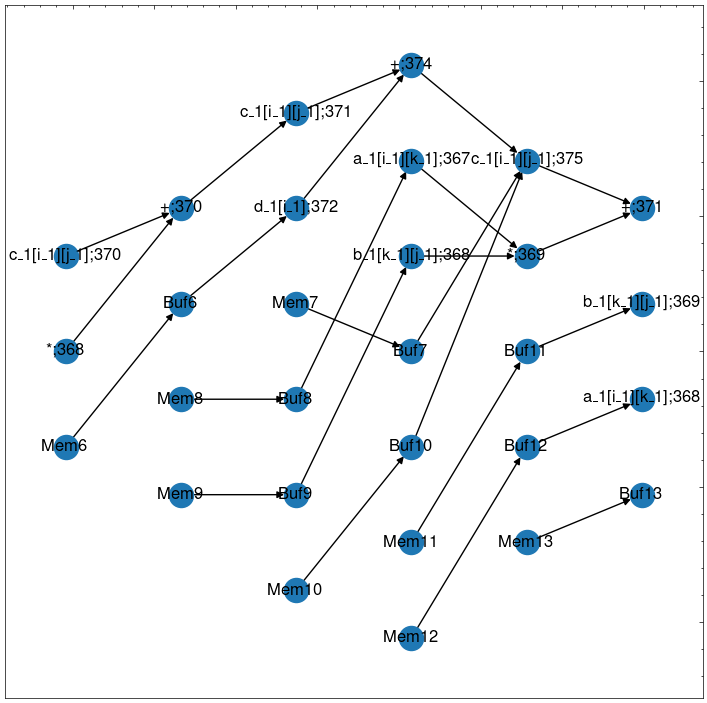

In [58]:
rev = nx.reverse(computation_dfg)
gens = list(nx.topological_generations(rev))
print(gens)
rev_gens = reversed(gens)

for layer, nodes in enumerate(rev_gens):
    for node in nodes:
        computation_dfg.nodes[node]["layer"] = layer

# print(f"nodes: {computation_dfg.nodes.data(True)}")

pos = nx.multipartite_layout(computation_dfg, subset_key="layer")

# print(f"nodes: {computation_dfg.nodes}")
layer_start = 5
layer_size = 6
sub_nodes = list(filter(lambda x: computation_dfg.nodes[x]["layer"] >= layer_start and computation_dfg.nodes[x]["layer"] < layer_start + layer_size, computation_dfg.nodes))
print(f"sub nodes: {sub_nodes}")
sub_comp_graph = computation_dfg.subgraph(sub_nodes)

fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(sub_comp_graph, pos=pos, ax=ax)
plt.show()

In [ ]:
total_cycles = 0

# TODO: this doesn't account for latency of each element.
# just assumes all have equal latency.
longest_path = nx.dag_longest_path(hw_graph)
# print(f"longest_path: {longest_path}")
try:
    total_cycles = sum(
        [math.ceil(hw.latency[hw_graph.nodes[n]["function"]]) for n in longest_path]
    )  # + math.ceil(hw.latency["Regs"]) # add latency of Reg because initial read reg cost is not included in longest path.
except:
    total_cycles = 0

self.cycles += total_cycles

# print(f"hw_graph before sim_cycle: {str(hw_graph)}")
self.simulate_cycles(hw, temp_c, total_cycles)
# print(f"hw_graph after sim_cycle: {str(hw_graph)}")

# hardwareModel.un_allocate_all_in_use_elements(hw.netlist)


self.node_intervals[-1][1][1] = self.cycles
for free in frees:
    self.process_memory_operation(
        free,
        list(hardwareModel.get_memory_node(hw.netlist).values())[0]["memory_module"],
    )
mallocs = []
frees = []
visited_node_ids.add(node_id)
i = next_ind
pattern_seek = pattern_seek_next
max_iters = max_iters_next

# === Count mem usage ===
mem_in_use = self.get_mem_usage_of_dfg_node(
    temp_c,
    list(hardwareModel.get_memory_node(hw.netlist).values())[0]["memory_module"],
)  # does this result in double counting if a reg appears in two different temp_c's?

self.max_regs_inuse = min(
    hardwareModel.num_nodes_with_func(hw.netlist, "Regs"),
    self.max_regs_inuse,
)
self.max_mem_inuse = max(self.max_mem_inuse, mem_in_use)
# === End count mem usage ===

# add all passive power at the end.
# This is done here for the dynamic allocation case where we don't know how many
# compute elements we need until we run the program.
for elem_name, elem_data in dict(hw.netlist.nodes.data()).items():
    scaling = 1
    if elem_data["function"] in ["Regs", "Buf", "MainMem"]:
        scaling = elem_data["size"]
    # OLD PASSIVE POWER CALCULATION
    self.passive_power_dissipation_rate += (
        hw.leakage_power[elem_data["function"]] * scaling
    )
    # NEW PASSIVE ENERGY CALCULATION
    self.total_energy += (
        hw.leakage_power[elem_data["function"]]
        * 1e-9
        * (self.cycles / hw.frequency)
        * scaling
    )

for node in hw.netlist.nodes:
    hw.netlist.nodes[node]["allocation"] = len(hw.netlist.nodes[node]["allocation"])

Running simulator for matmult.py
memory needed: 636 bytes
nvm memory needed: 0 bytes
compute area: 15250.0102972 um^2
memory area: 8260000.0 um^2
total area: 8275250.0102972 um^2
total number of cycles:  116
Avg compute Power: 0.20197537048 mW
Avg mem Power: 84.488 mW
Total power: 84.68997537048 mW
total volatile reads:  63
total volatile read size:  5700
total nvm reads:  0
total nvm read size:  0
total writes:  12
total write size:  384

In [262]:
pe_i = 0.00505340876892468
t_i = 30.9972376005051
pe_f = 0.015046489783685094
t_f = 59.21692502261995

In [263]:
pp_i = pe_i / t_i
pp_f = pe_f / t_f

In [264]:
print(f"pp_i: {pp_i}, pp_f: {pp_f}")

pp_i: 0.00016302771343864315, pp_f: 0.00025409103525618005
